In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("lightcurve_features_26.csv")

In [2]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
subset_100 = df_shuffled.iloc[:100]
subset_39 = df_shuffled.iloc[100:139]

In [4]:
subset_39.to_csv("Positive_hidden_subset_39.csv", index=False)

In [5]:
subset_100.to_csv("positive_100_elements.csv", index=False)

In [71]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN #utilizing DBSCAN for density-based clustering
from sklearn.preprocessing import StandardScaler # It transforms data such that it has a mean of 0 and a standard deviation of 1

# Load your negative sample
df_neg = pd.read_csv("lightcurve_features_26_negative.parquet")


In [72]:
features = df_neg.select_dtypes(include=[np.number]) #nonnumericals are dropped
features = features.replace([np.inf, -np.inf], np.nan)
features = features.dropna()

In [73]:
print(features.shape)
print(features.columns)

(1471, 26)
Index(['mean', 'weighted_mean', 'standard_deviation', 'median', 'amplitude',
       'beyond_1_std', 'cusum', 'inter_percentile_range_10', 'kurtosis',
       'linear_trend', 'linear_trend_sigma', 'linear_trend_noise',
       'linear_fit_slope', 'linear_fit_slope_sigma', 'linear_fit_reduced_chi2',
       'magnitude_percentage_ratio_40_5', 'magnitude_percentage_ratio_20_10',
       'maximum_slope', 'median_absolute_deviation',
       'median_buffer_range_percentage_10', 'percent_amplitude',
       'mean_variance', 'anderson_darling_normal', 'chi2', 'skew',
       'stetson_K'],
      dtype='object')


In [11]:
features = df_neg.select_dtypes(include=[np.number])
X = StandardScaler().fit_transform(features) #standardize and transforming features

In [12]:
db = DBSCAN(eps=2.36, min_samples=5).fit(X)

In [13]:
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print("Clusters:", n_clusters)
print("Noise points:", list(db.labels_).count(-1))

Clusters: 11
Noise points: 366


In [15]:
# If X is a DataFrame:
if isinstance(X, pd.DataFrame):
    df = X.copy()
else:
    # If X is a numpy array, create a DataFrame for easier handling
    df = pd.DataFrame(X)

In [16]:
# Add cluster labels to your data
df['cluster'] = db.labels_
# Identify noise points (label = -1)
noise_points = df[df['cluster'] == -1]

In [74]:
# Save to CSV
noise_points.to_parquet('negative_subset_noise_points.parquet', index=False)

print(f"✅ Saved {len(noise_points)} noise points to noise_points.parquet")

✅ Saved 366 noise points to noise_points.parquet


In [75]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load your data
df_neg = pd.read_csv("lightcurve_features_26_negative.parquet")  # ✅ Use correct file format

# Select only numeric columns (DBSCAN works on numeric data)
numeric_features = df_neg.select_dtypes(include=[np.number])

# Standardize numeric columns
X_scaled = StandardScaler().fit_transform(numeric_features)

# Apply DBSCAN clustering
db = DBSCAN(eps=2.36, min_samples=5)
clusters = db.fit_predict(X_scaled)

# Store cluster labels back in the DataFrame
df_neg["cluster"] = clusters

# View number of points per cluster
print(df_neg["cluster"].value_counts())


cluster
 1     1032
-1      366
 2       19
 8        8
 0        7
 3        7
 10       7
 6        6
 5        5
 4        5
 7        5
 9        4
Name: count, dtype: int64


In [26]:
import pandas as pd
import numpy as np

# Filter out noise
clustered = df_neg[df_neg['cluster'] != -1]

# Number of clusters
clusters = clustered['cluster'].unique()
n_clusters = len(clusters)

# Target total negatives
target_total = 100
sample_per_cluster = target_total // n_clusters  # ~9 per cluster

# Sample equally from each cluster
sampled_list = []

for c in clusters:
    subset = clustered[clustered['cluster'] == c]
    if len(subset) >= sample_per_cluster:
        sampled = subset.sample(sample_per_cluster, random_state=42)
    else:
        # If a cluster is too small, take all its members
        sampled = subset
    sampled_list.append(sampled)

sampled_negatives = pd.concat(sampled_list)

# If total < 100, fill remaining from large clusters
remaining = target_total - len(sampled_negatives)
if remaining > 0:
    large_clusters = clustered.groupby('cluster').size().sort_values(ascending=False).index
    for c in large_clusters:
        if remaining <= 0:
            break
        subset = clustered[clustered['cluster'] == c]
        add = subset.sample(min(remaining, len(subset)), random_state=42)
        sampled_negatives = pd.concat([sampled_negatives, add])
        remaining -= len(add)

sampled_negatives = sampled_negatives.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle



In [27]:
import pandas as pd
import numpy as np

# df_neg must contain a column 'cluster' (from DBSCAN)
# Example:
# df_neg = pd.read_parquet("negatives_lightcurves_grouped_r_clean.parquet")

# remove noise points (-1) if you don’t want to include them
df_clusters = df_neg[df_neg['cluster'] != -1].copy()

subset_size = 100
num_subsets = 11

def make_subset(df, seed=0, subset_size=100):
    rng = np.random.default_rng(seed)
    clusters = df['cluster'].unique()
    n_clusters = len(clusters)
    per_cluster = subset_size // n_clusters
    
    samples = []
    for c in clusters:
        group = df[df['cluster'] == c]
        take = min(per_cluster, len(group))
        samples.append(group.sample(take, random_state=int(rng.integers(1e9))))
    
    subset = pd.concat(samples)
    # If we got less than subset_size, fill remaining randomly
    if len(subset) < subset_size:
        remaining = subset_size - len(subset)
        extra = df.sample(remaining, random_state=int(rng.integers(1e9)))
        subset = pd.concat([subset, extra])
        
    subset = subset.sample(frac=1, random_state=int(rng.integers(1e9))).reset_index(drop=True)
    return subset

# Generate and save 11 subsets
for i in range(num_subsets):
    subset = make_subset(df_clusters, seed=i, subset_size=subset_size)
    fname = f"negative_subset_{i+1}.parquet"
    subset.to_parquet(fname, index=False)
    print(f"Saved {fname} with {len(subset)} samples")


Saved negative_subset_1.parquet with 100 samples
Saved negative_subset_2.parquet with 100 samples
Saved negative_subset_3.parquet with 100 samples
Saved negative_subset_4.parquet with 100 samples
Saved negative_subset_5.parquet with 100 samples
Saved negative_subset_6.parquet with 100 samples
Saved negative_subset_7.parquet with 100 samples
Saved negative_subset_8.parquet with 100 samples
Saved negative_subset_9.parquet with 100 samples
Saved negative_subset_10.parquet with 100 samples
Saved negative_subset_11.parquet with 100 samples


In [31]:
df_neg_1 = pd.read_parquet("negative_subset_1.parquet")
features_neg_1 = df_neg_1.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_1 = features_neg_1.select_dtypes(include='number')
corr_neg_1 = features_neg_numeric_1.corr()


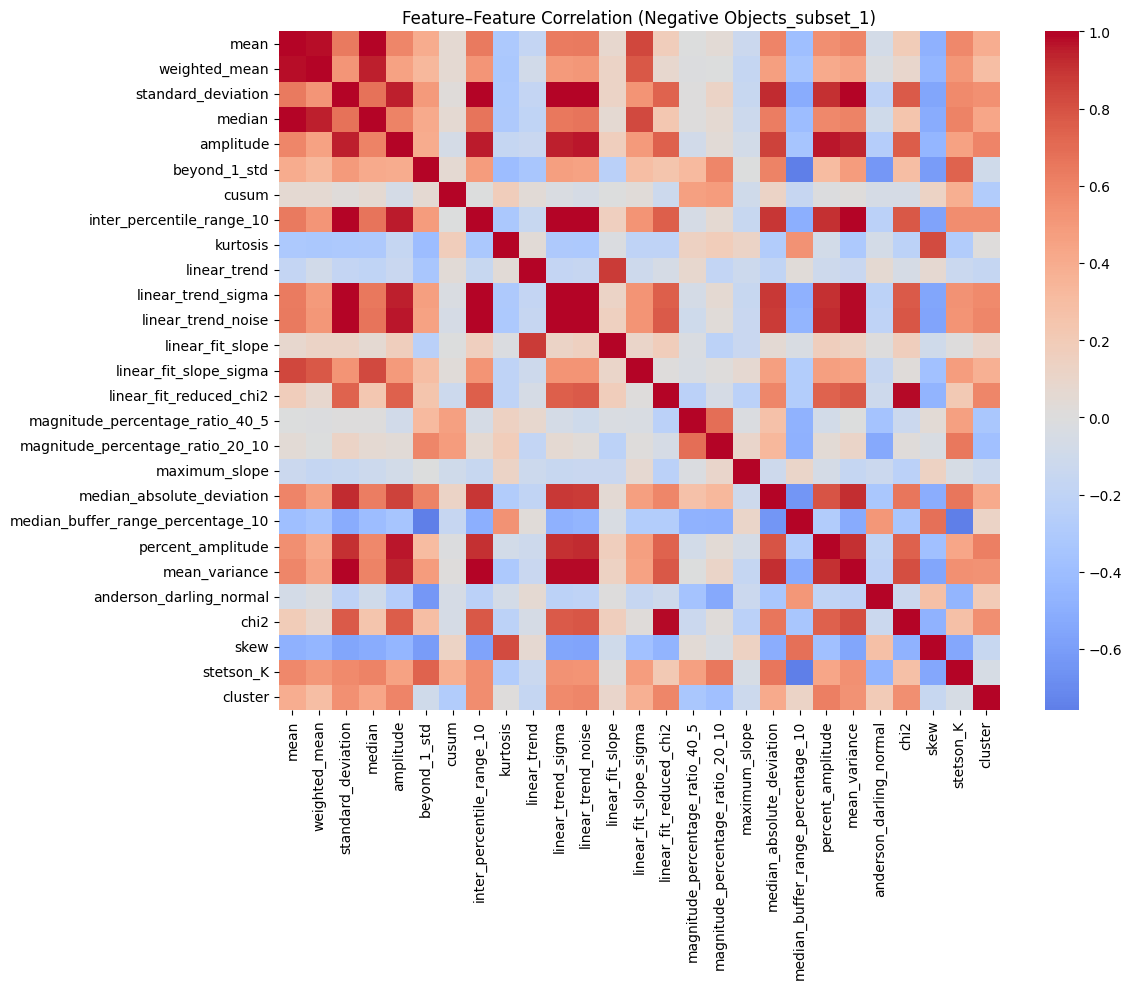

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_1, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_1)')
plt.tight_layout()
plt.show()


In [36]:
df_neg_2 = pd.read_parquet("negative_subset_2.parquet")
features_neg_2 = df_neg_2.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_2 = features_neg_2.select_dtypes(include='number')
corr_neg_2 = features_neg_numeric_2.corr()


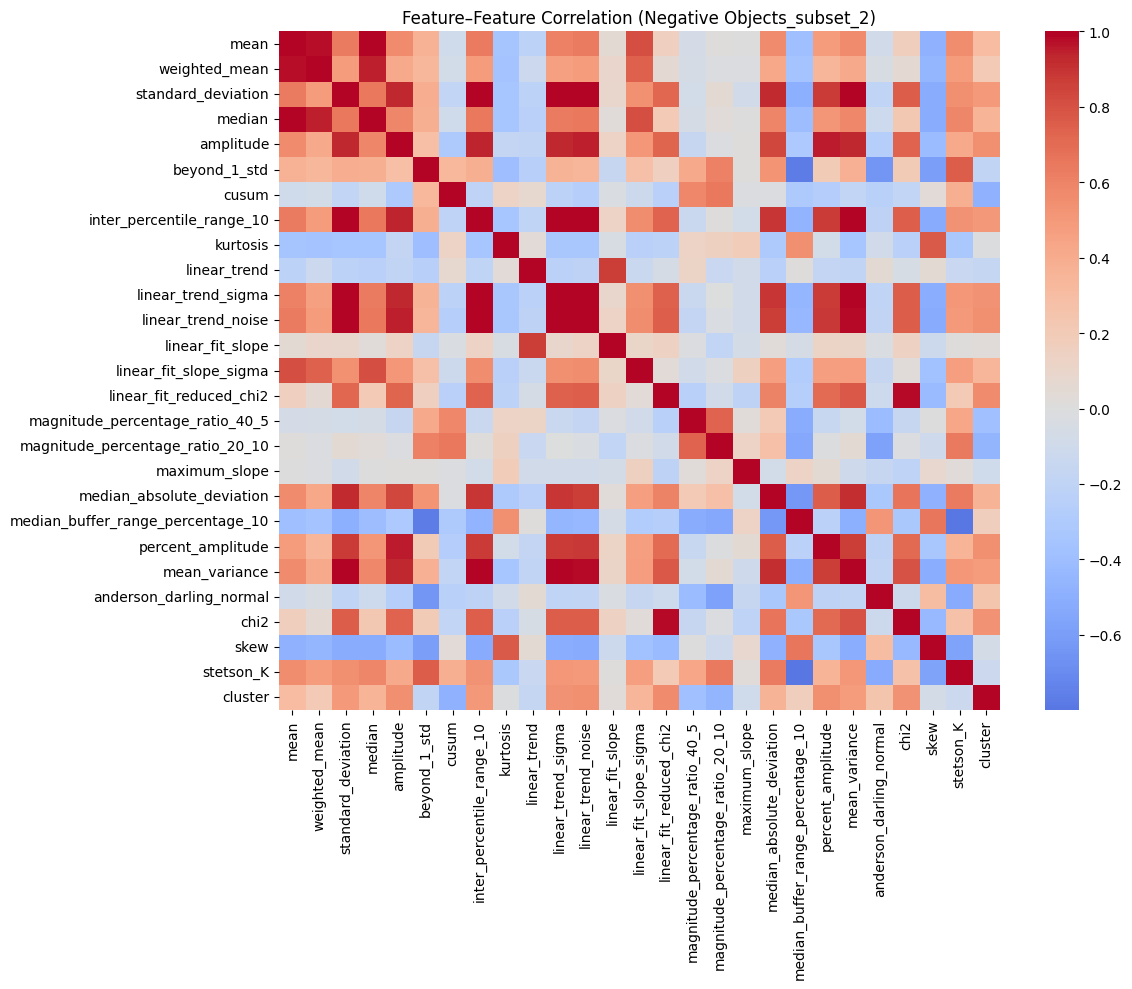

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_2, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_2)')
plt.tight_layout()
plt.show()


In [41]:
df_neg_3 = pd.read_parquet("negative_subset_3.parquet")
features_neg_3 = df_neg_3.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_3 = features_neg_3.select_dtypes(include='number')
corr_neg_3 = features_neg_numeric_3.corr()


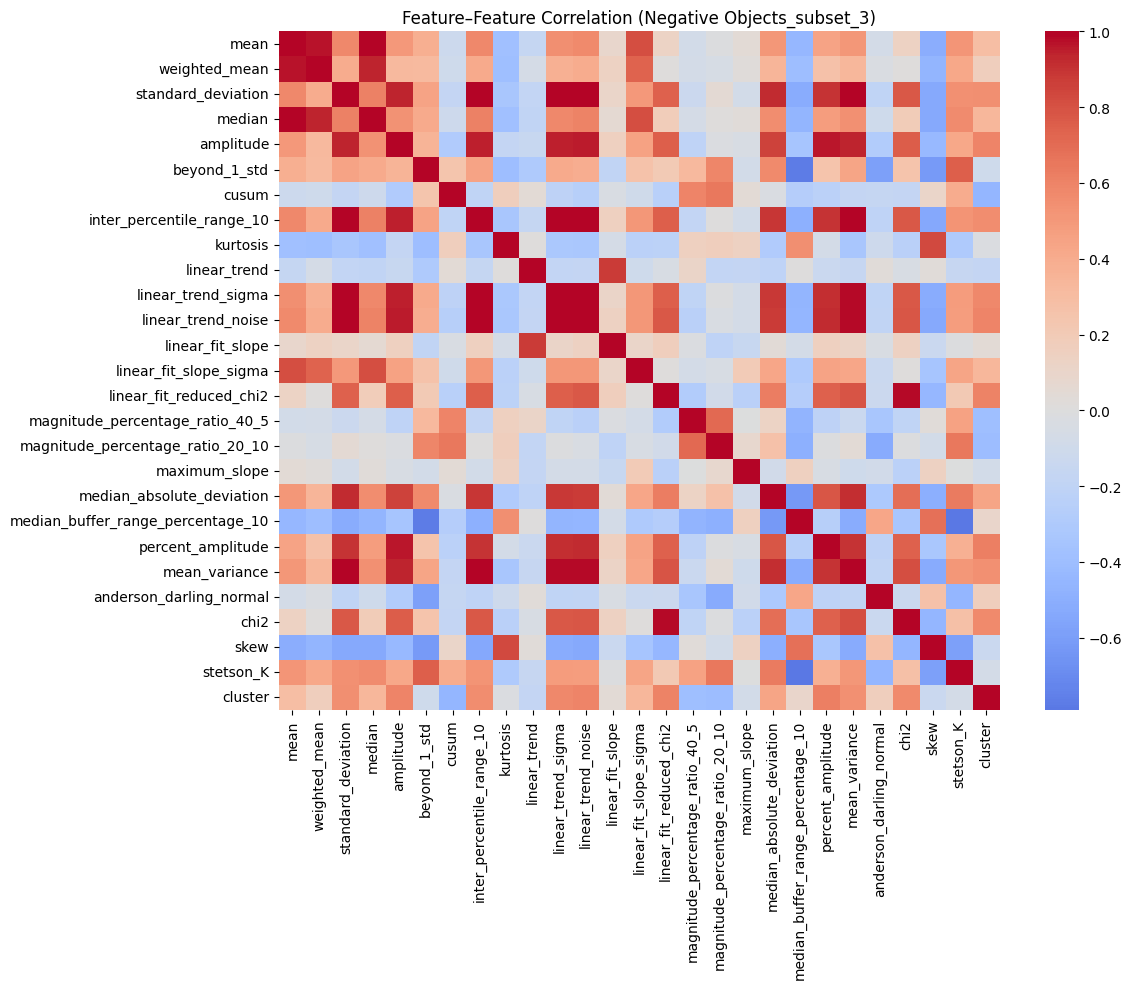

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_3, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_3)')
plt.tight_layout()
plt.show()


In [52]:
df_neg_4 = pd.read_parquet("negative_subset_4.parquet")
features_neg_4 = df_neg_4.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_4 = features_neg_4.select_dtypes(include='number')
corr_neg_4 = features_neg_numeric_4.corr()


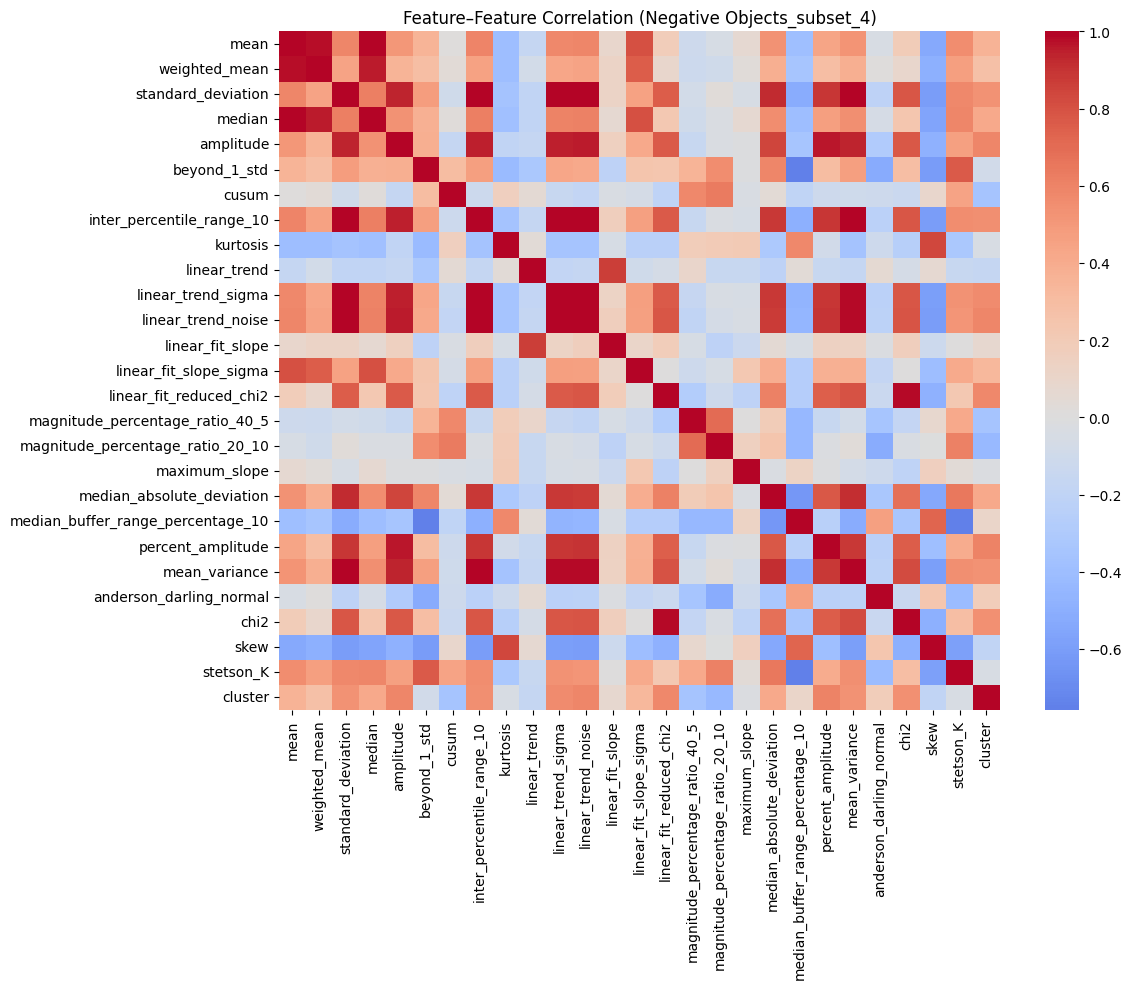

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_4, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_4)')
plt.tight_layout()
plt.show()


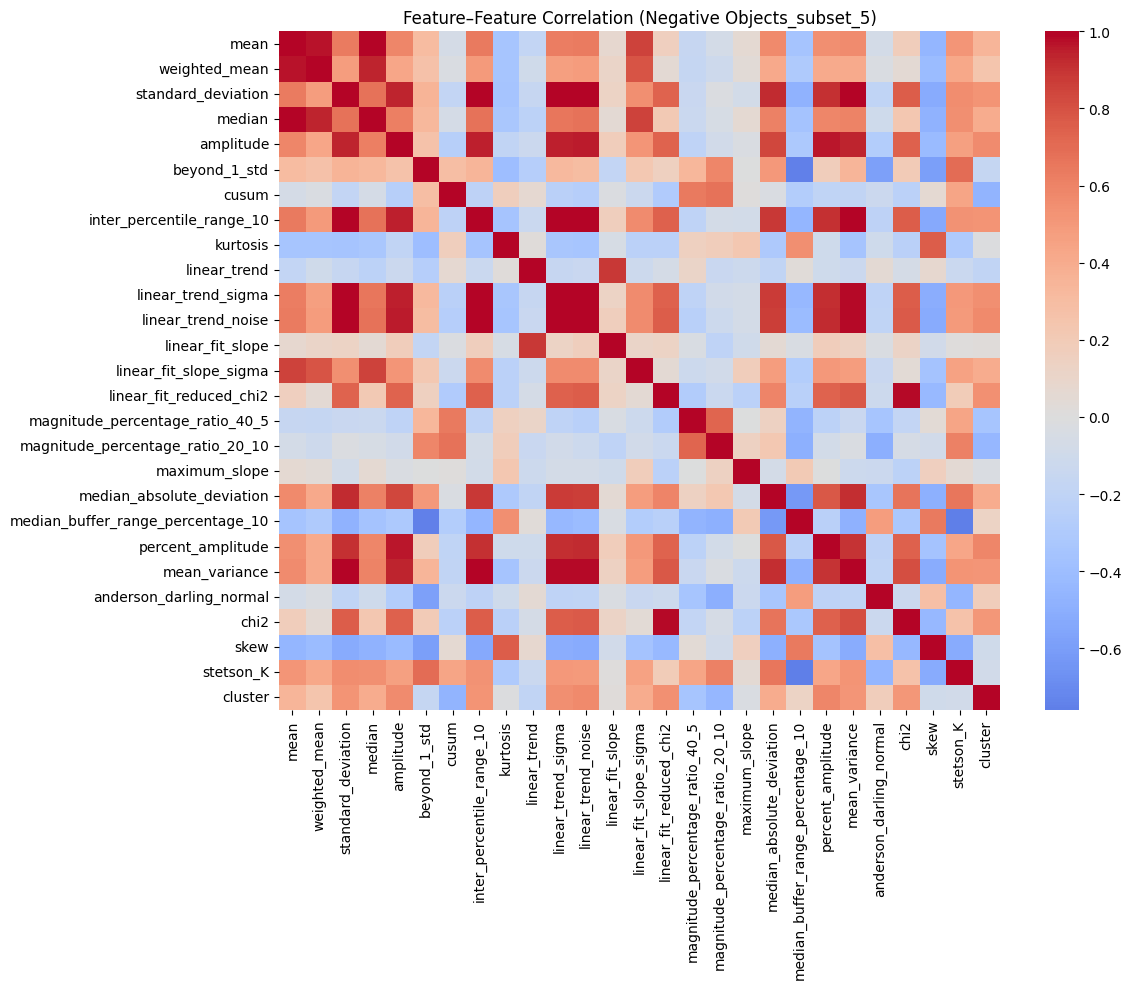

In [51]:
df_neg_5 = pd.read_parquet("negative_subset_5.parquet")
features_neg_5 = df_neg_5.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_5 = features_neg_5.select_dtypes(include='number')
corr_neg_5 = features_neg_numeric_5.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_5, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_5)')
plt.tight_layout()
plt.show()


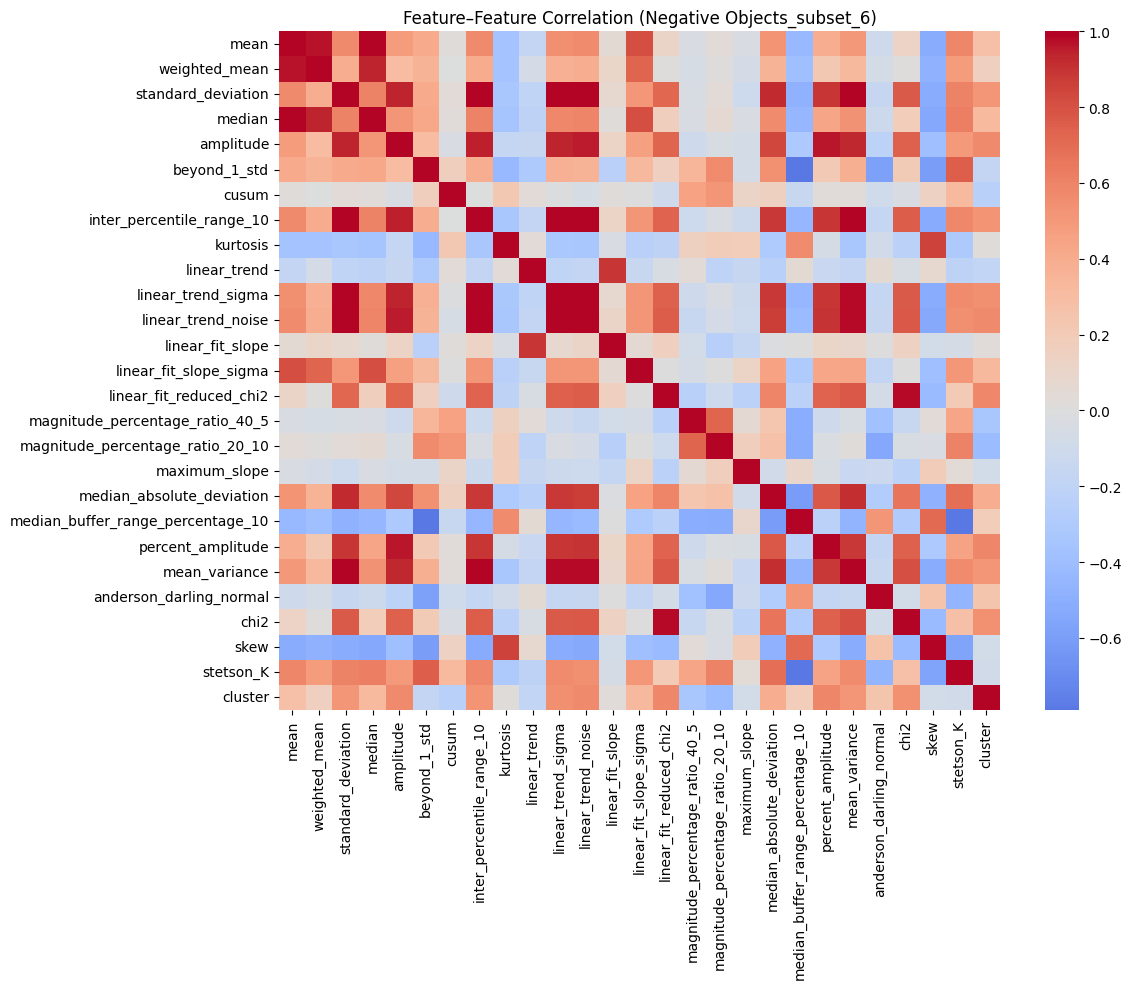

In [50]:
df_neg_6= pd.read_parquet("negative_subset_6.parquet")
features_neg_6 = df_neg_6.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_6 = features_neg_6.select_dtypes(include='number')
corr_neg_6 = features_neg_numeric_6.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_6, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_6)')
plt.tight_layout()
plt.show()


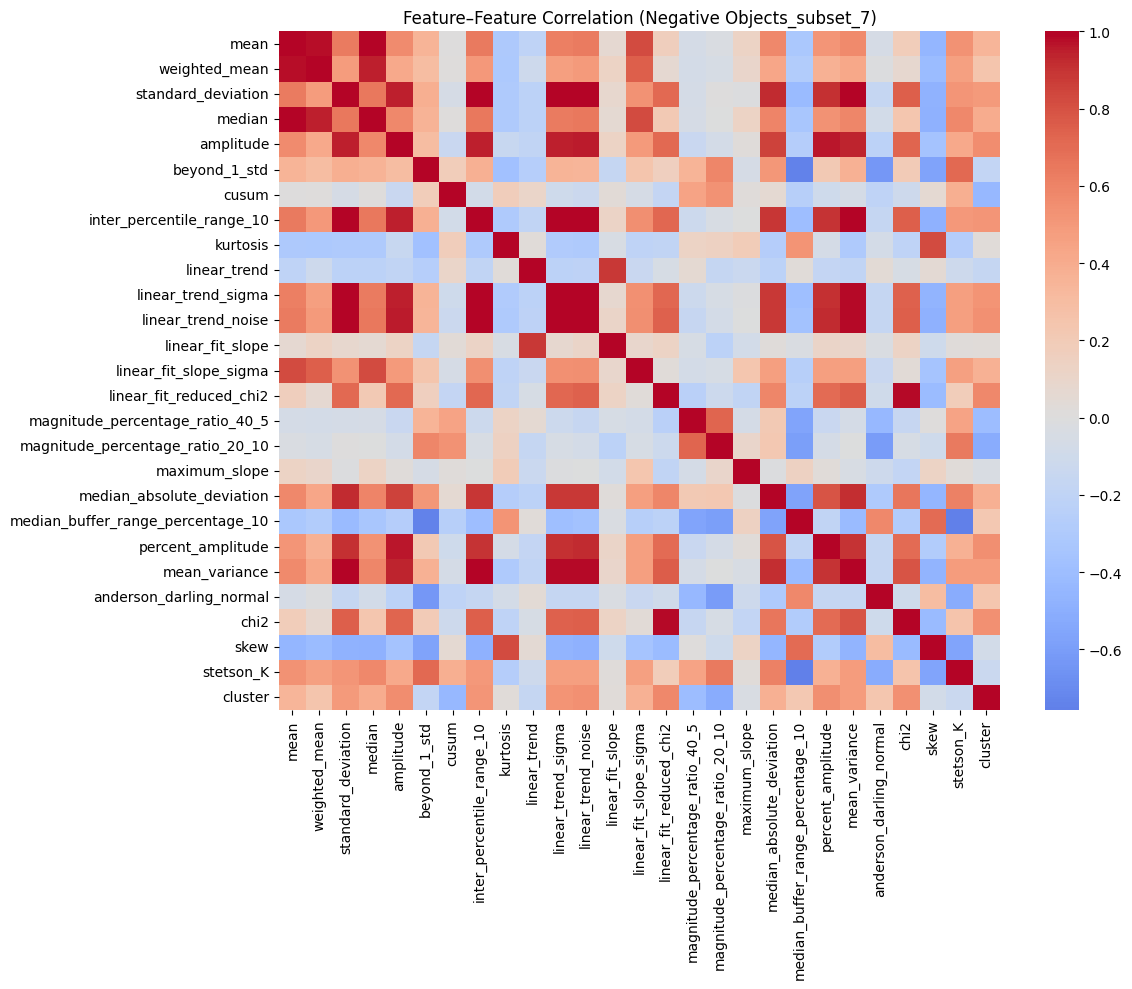

In [48]:
df_neg_7= pd.read_parquet("negative_subset_7.parquet")
features_neg_7 = df_neg_7.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_7 = features_neg_7.select_dtypes(include='number')
corr_neg_7 = features_neg_numeric_7.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_7, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_7)')
plt.tight_layout()
plt.show()


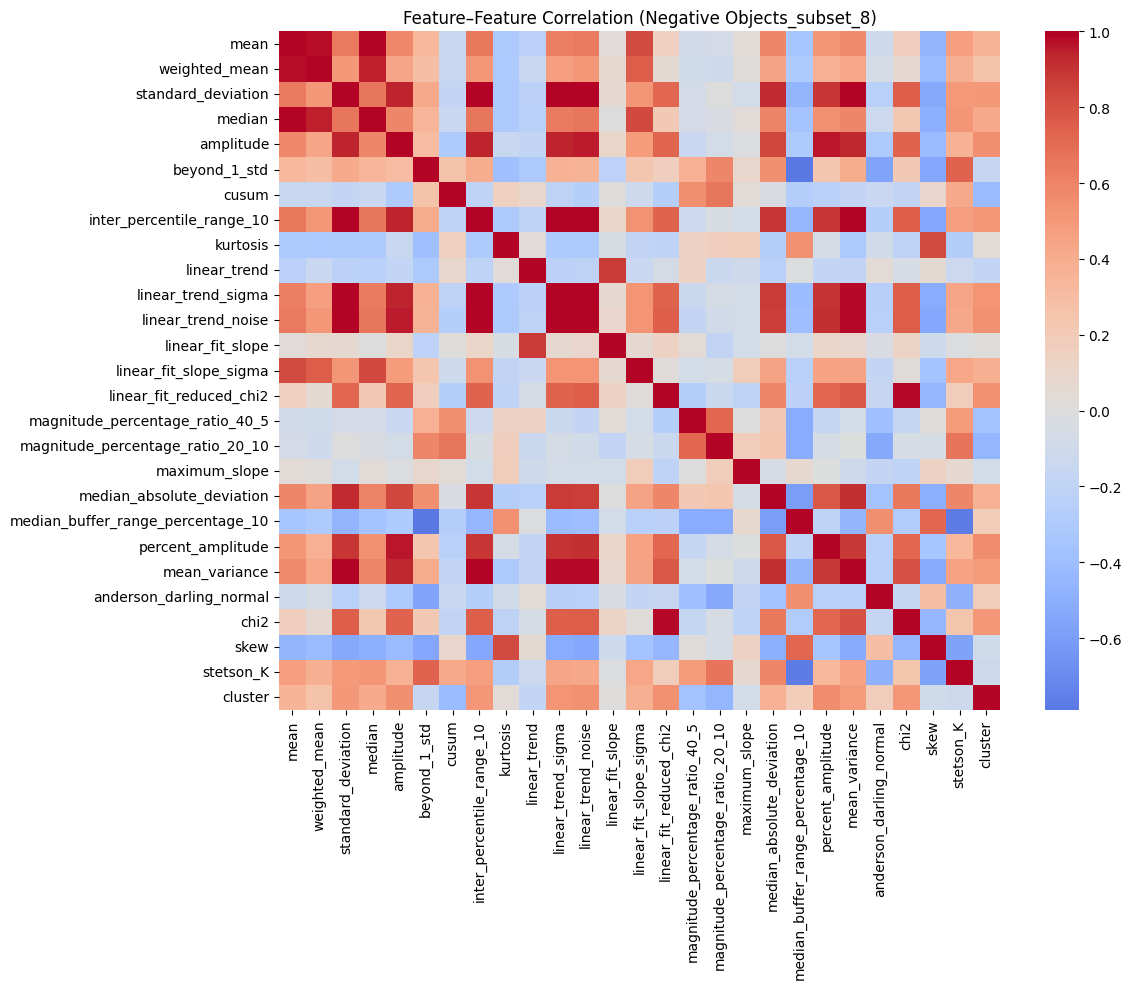

In [55]:
df_neg_8= pd.read_parquet("negative_subset_8.parquet")
features_neg_8 = df_neg_8.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_8 = features_neg_8.select_dtypes(include='number')
corr_neg_8 = features_neg_numeric_8.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_8, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_8)')
plt.tight_layout()
plt.show()


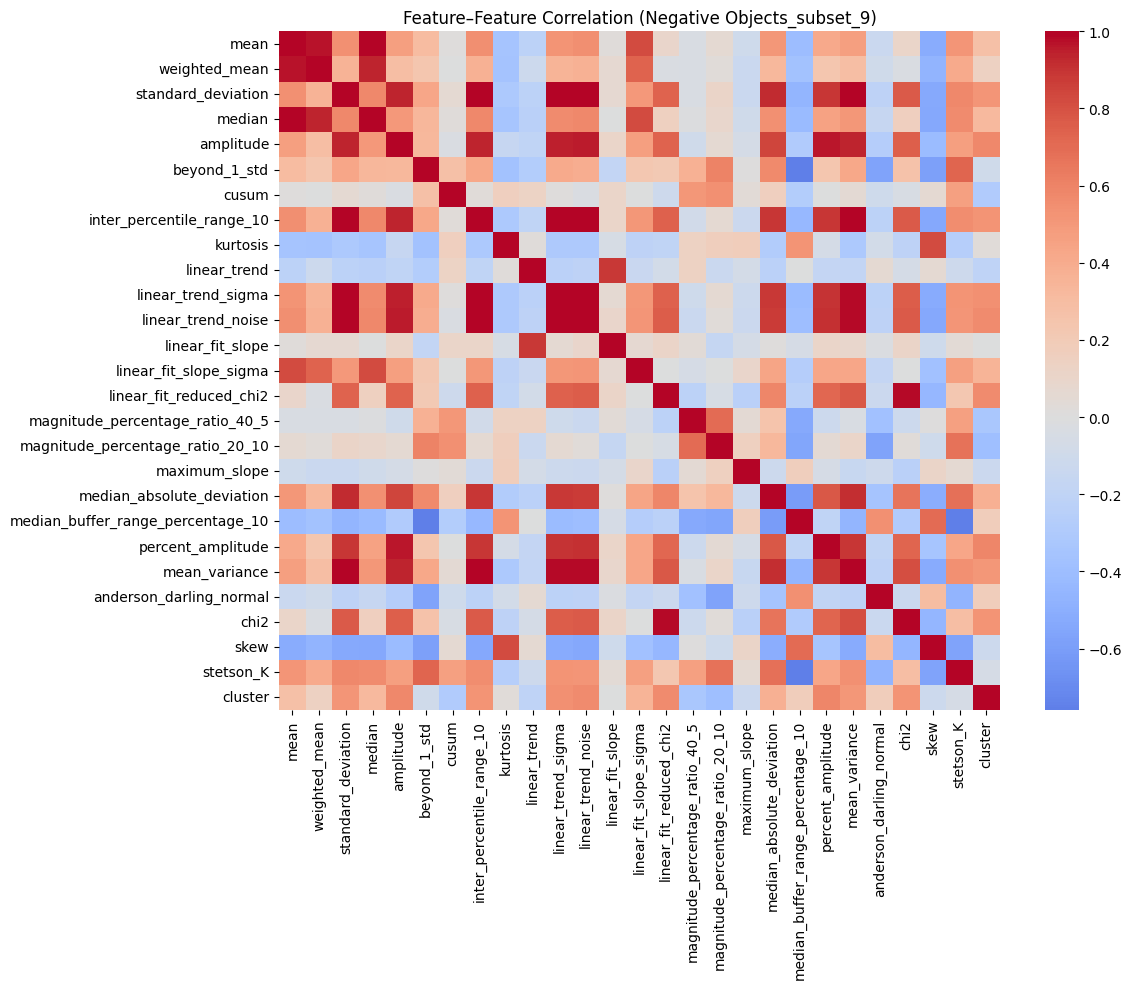

In [56]:
df_neg_9= pd.read_parquet("negative_subset_9.parquet")
features_neg_9 = df_neg_9.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_9 = features_neg_9.select_dtypes(include='number')
corr_neg_9 = features_neg_numeric_9.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_9, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_9)')
plt.tight_layout()
plt.show()


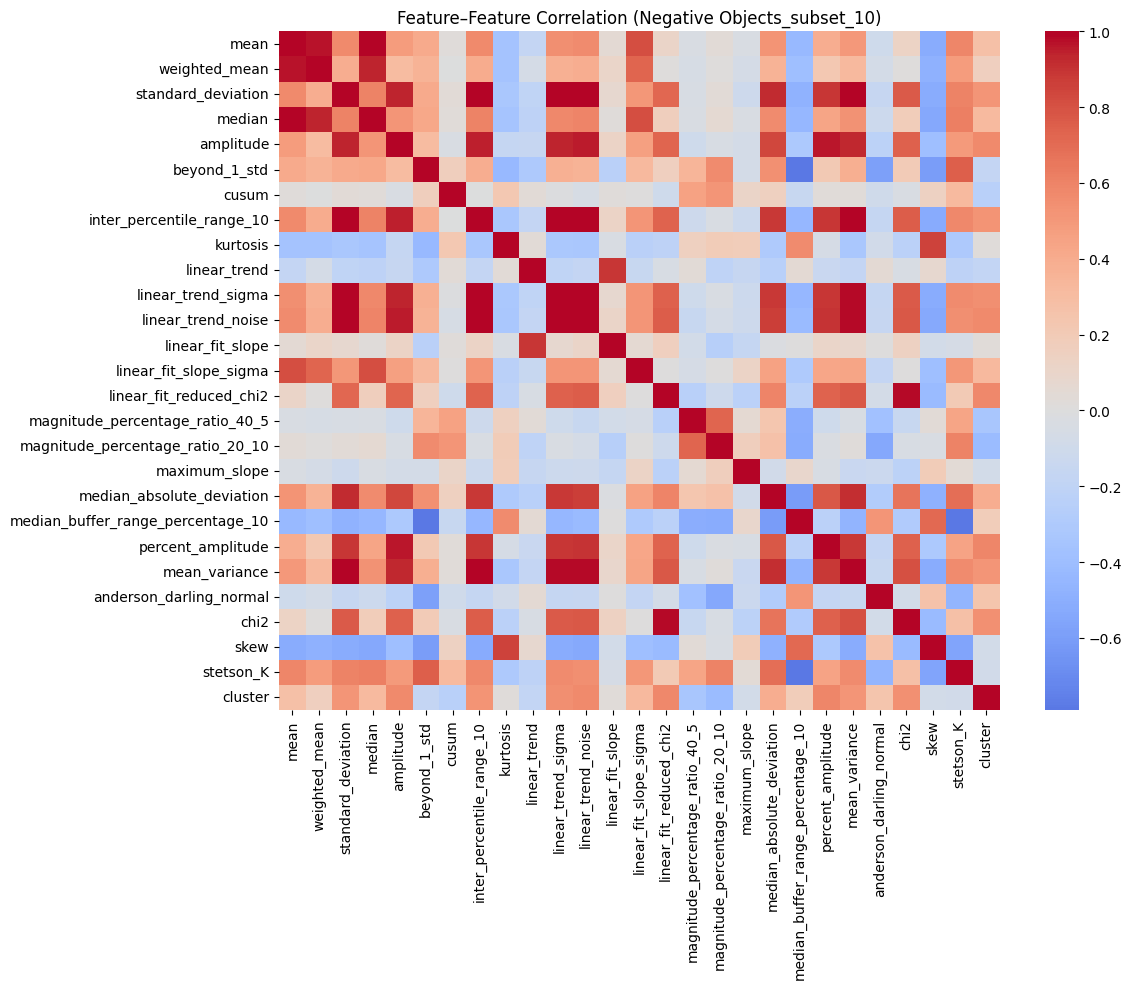

In [57]:
df_neg_10= pd.read_parquet("negative_subset_10.parquet")
features_neg_10 = df_neg_10.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_10 = features_neg_10.select_dtypes(include='number')
corr_neg_10 = features_neg_numeric_6.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_10, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_10)')
plt.tight_layout()
plt.show()


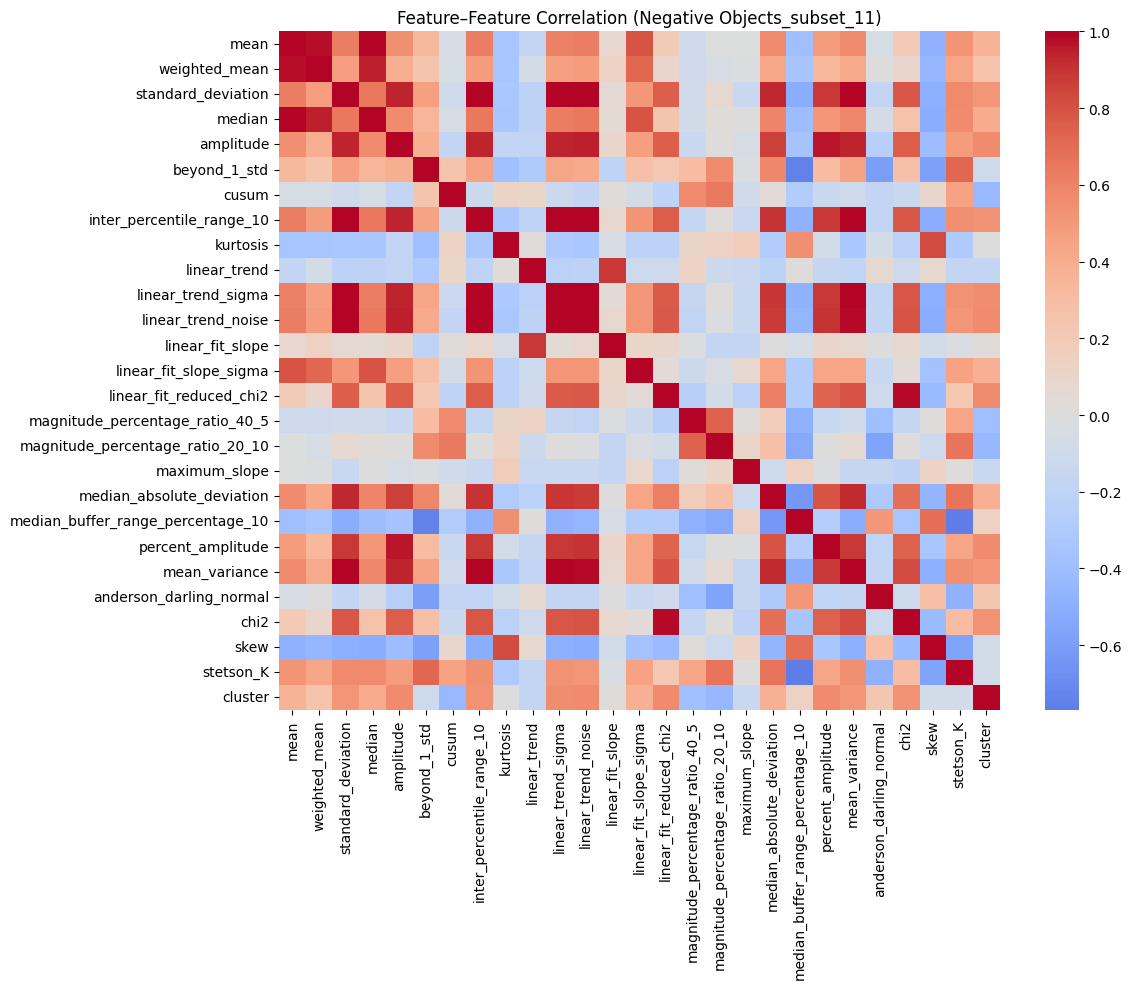

In [58]:
df_neg_11= pd.read_parquet("negative_subset_11.parquet")
features_neg_11 = df_neg_11.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_11 = features_neg_11.select_dtypes(include='number')
corr_neg_11 = features_neg_numeric_11.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_11, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Negative Objects_subset_11)')
plt.tight_layout()
plt.show()


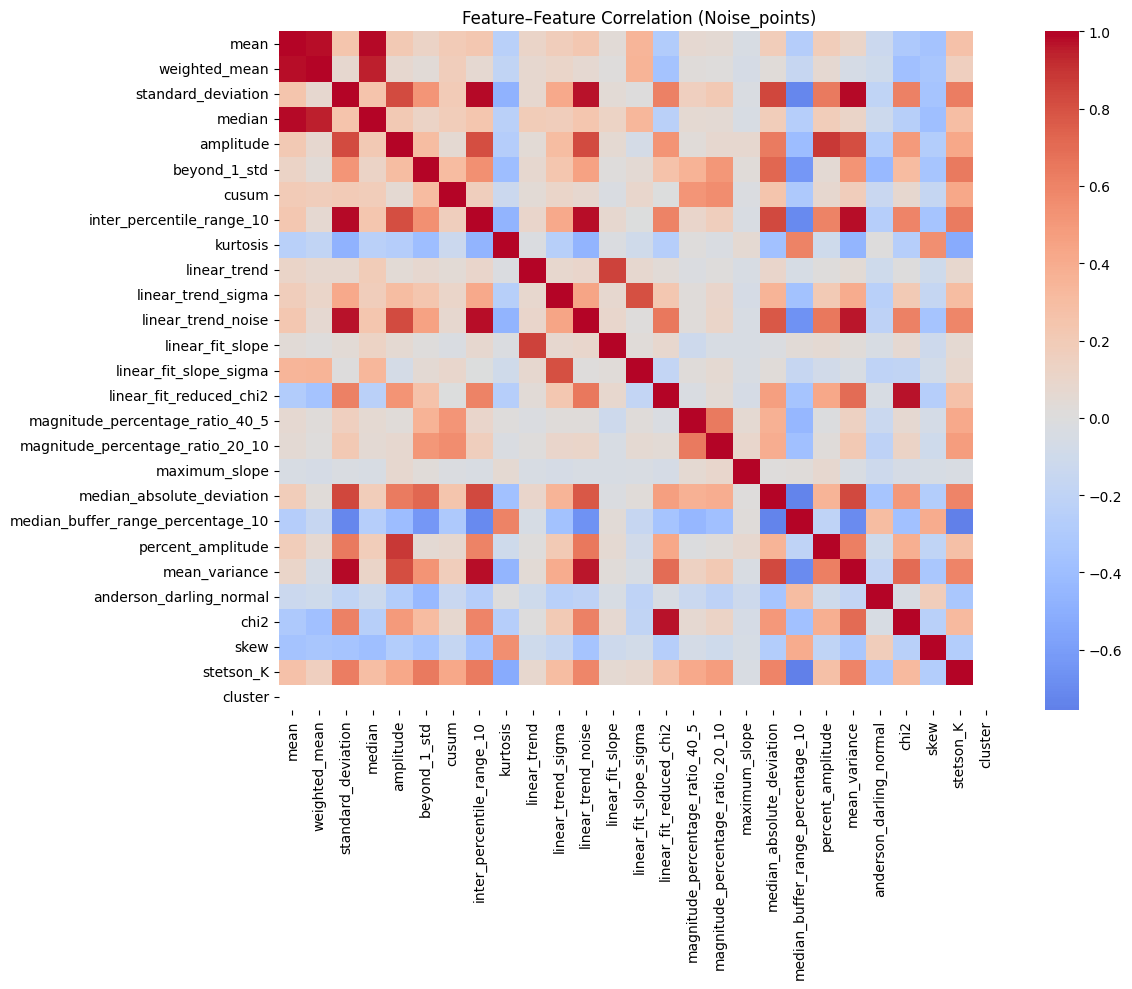

In [60]:
df_neg_12= pd.read_csv("noise_points.csv")
features_neg_12 = df_neg_12.drop(columns=['object_name'], errors='ignore')
features_neg_numeric_12 = features_neg_12.select_dtypes(include='number')
corr_neg_12 = features_neg_numeric_12.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg_12, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (Noise_points)')
plt.tight_layout()
plt.show()


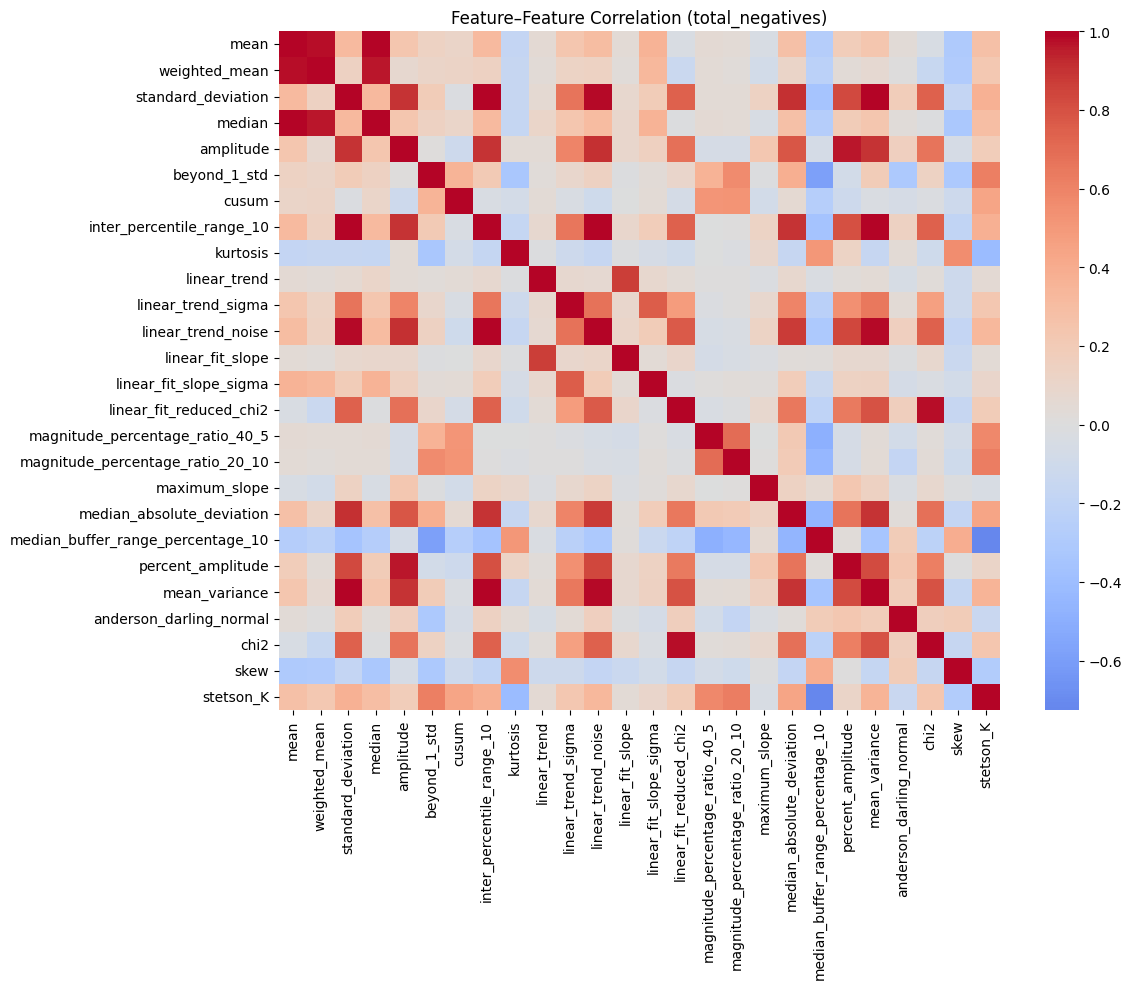

In [64]:
df_neg= pd.read_csv("lightcurve_features_26_negative.parquet")
features_neg = df_neg.drop(columns=['object_name'], errors='ignore')
features_neg_numeric = features_neg.select_dtypes(include='number')
corr_neg = features_neg_numeric.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_neg, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (total_negatives)')
plt.tight_layout()
plt.show()


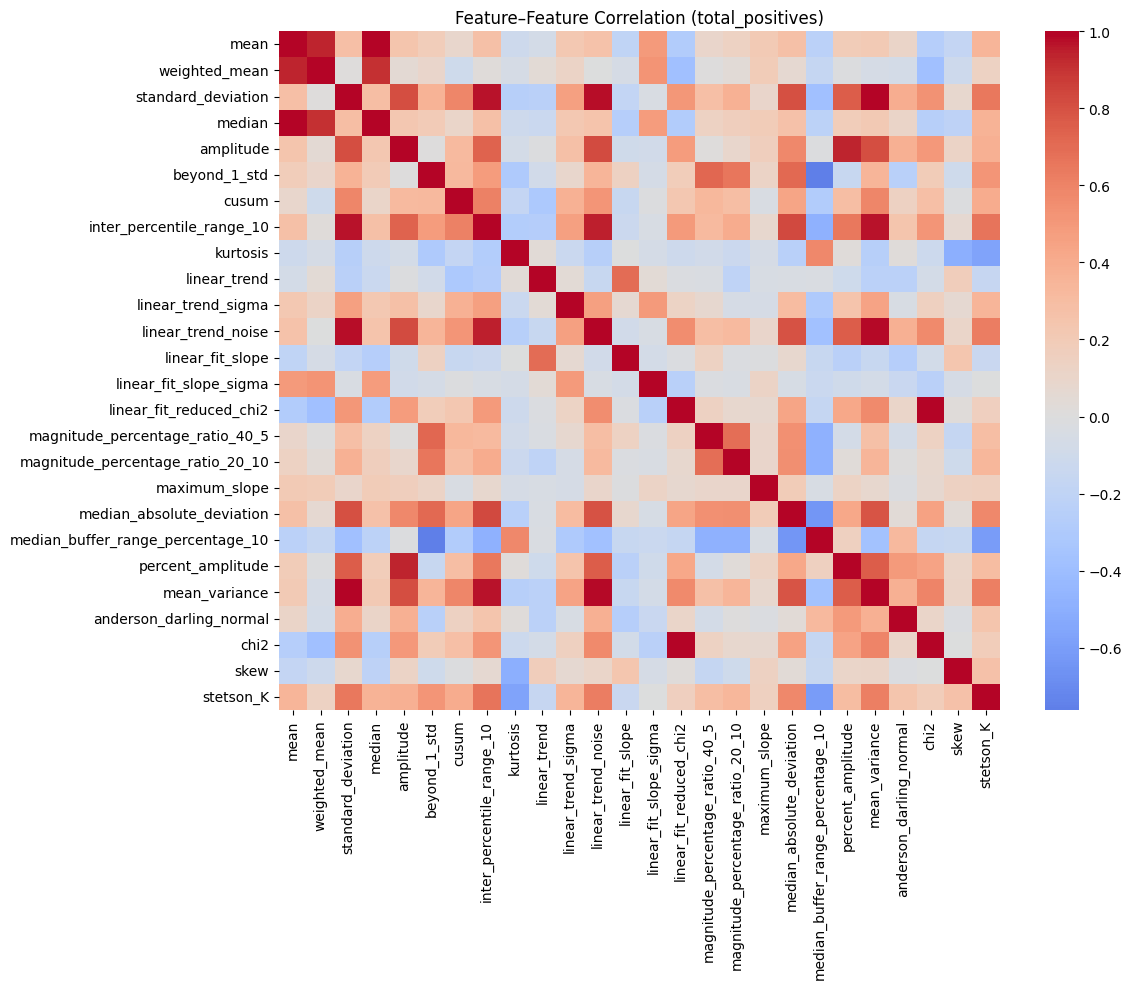

In [66]:
df_pos= pd.read_csv("positive_100_elements.csv")
features_pos = df_pos.drop(columns=['object_name'], errors='ignore')
features_pos_numeric = features_pos.select_dtypes(include='number')
corr_pos = features_pos_numeric.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_pos, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (total_positives)')
plt.tight_layout()
plt.show()


✅ Computed corr_diff_1 for negative_subset_1.parquet
✅ Computed corr_diff_2 for negative_subset_10.parquet
✅ Computed corr_diff_3 for negative_subset_11.parquet
✅ Computed corr_diff_4 for negative_subset_2.parquet
✅ Computed corr_diff_5 for negative_subset_3.parquet
✅ Computed corr_diff_6 for negative_subset_4.parquet
✅ Computed corr_diff_7 for negative_subset_5.parquet
✅ Computed corr_diff_8 for negative_subset_6.parquet
✅ Computed corr_diff_9 for negative_subset_7.parquet
✅ Computed corr_diff_10 for negative_subset_8.parquet
✅ Computed corr_diff_11 for negative_subset_9.parquet
✅ Computed corr_diff_12 for negative_subset_noise_points.parquet


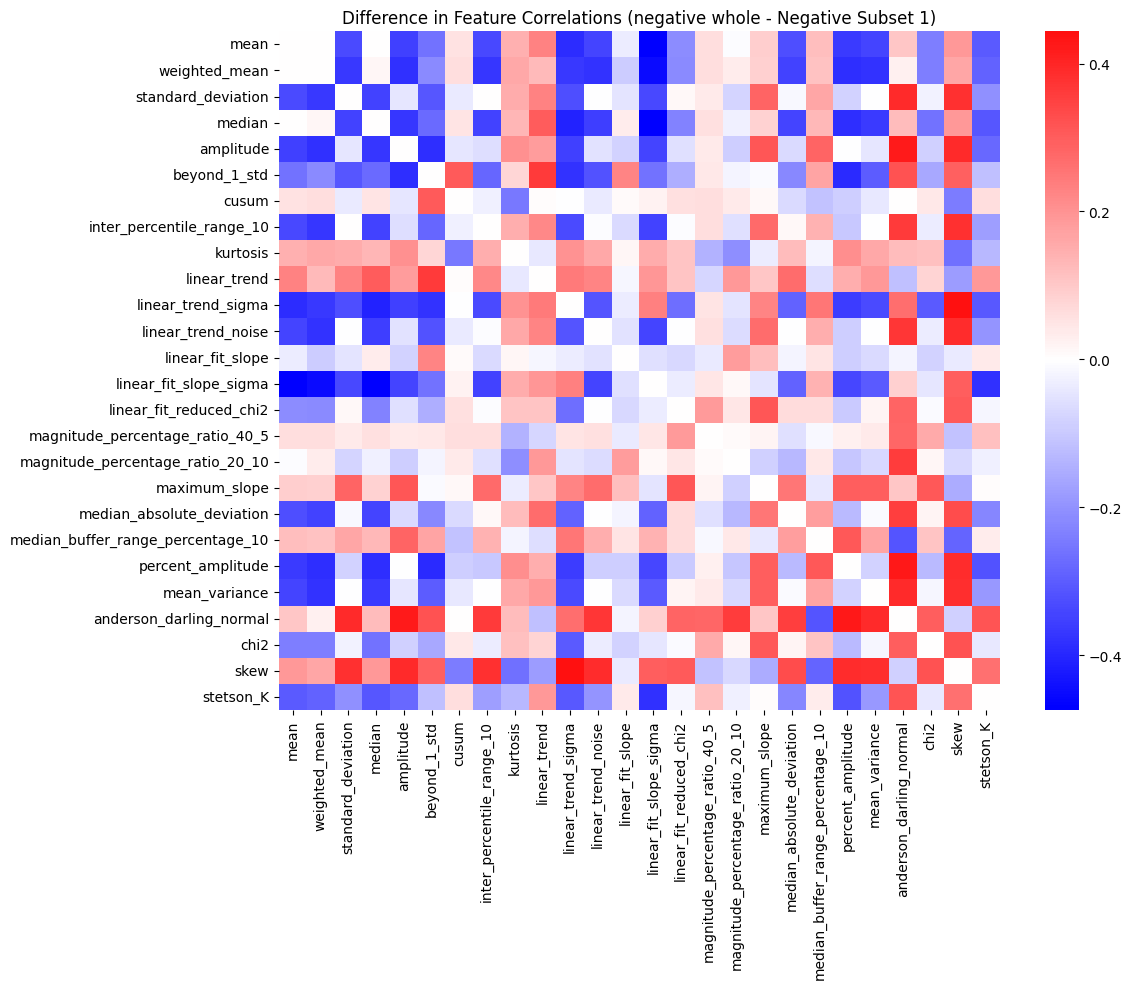

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

# --- Load  negative dataset correctly ---
df_negative = pd.read_csv("lightcurve_features_26_negative.parquet")  # use read_parquet, not read_csv

# Keep only numeric columns for correlation
corr_negative = df_negative.select_dtypes(include=[np.number]).corr()

# --- 2️⃣ Load all 12 negative subset files ---
neg_files = sorted(glob.glob("negative_subset_*.parquet"))

corr_diffs = {}

# --- 3️⃣ Compute correlation differences ---
for i, f in enumerate(neg_files, start=1):
    df_neg = pd.read_parquet(f)
    
    # Keep only numeric columns
    corr_neg = df_neg.select_dtypes(include=[np.number]).corr()
    
    # Ensure same column order
    corr_neg = corr_neg.reindex_like(corr_negative)
    
    # Compute difference
    corr_diff = corr_negative - corr_neg
    
    corr_diffs[f"corr_diff_{i}"] = corr_diff
    print(f"✅ Computed corr_diff_{i} for {f}")

# --- Visualize one example (say the first one) ---
corr_diff = corr_diffs["corr_diff_1"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset 1)")
plt.tight_layout()
plt.show()


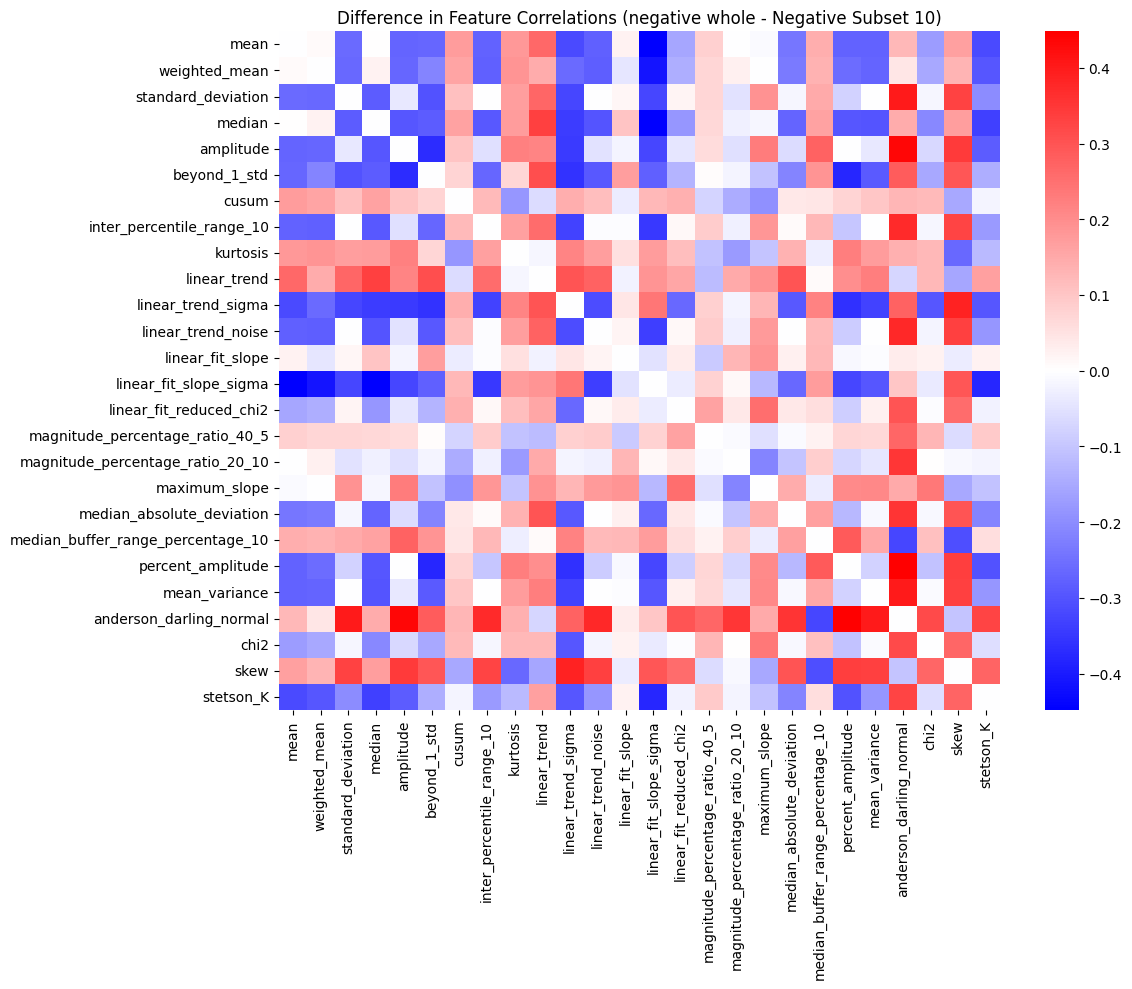

In [77]:
corr_diff = corr_diffs["corr_diff_2"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset 10)")
plt.tight_layout()
plt.show()

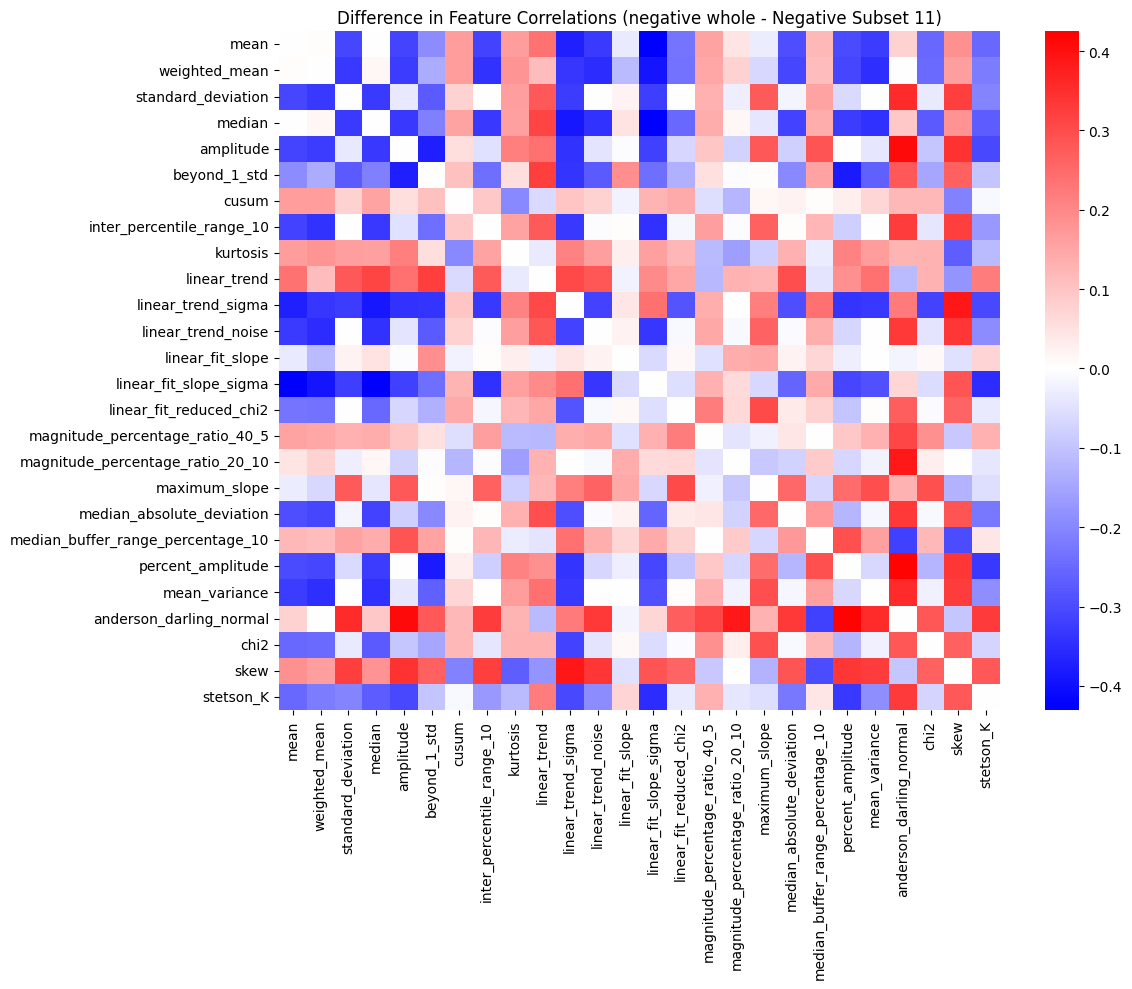

In [78]:
corr_diff = corr_diffs["corr_diff_3"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset 11)")
plt.tight_layout()
plt.show()

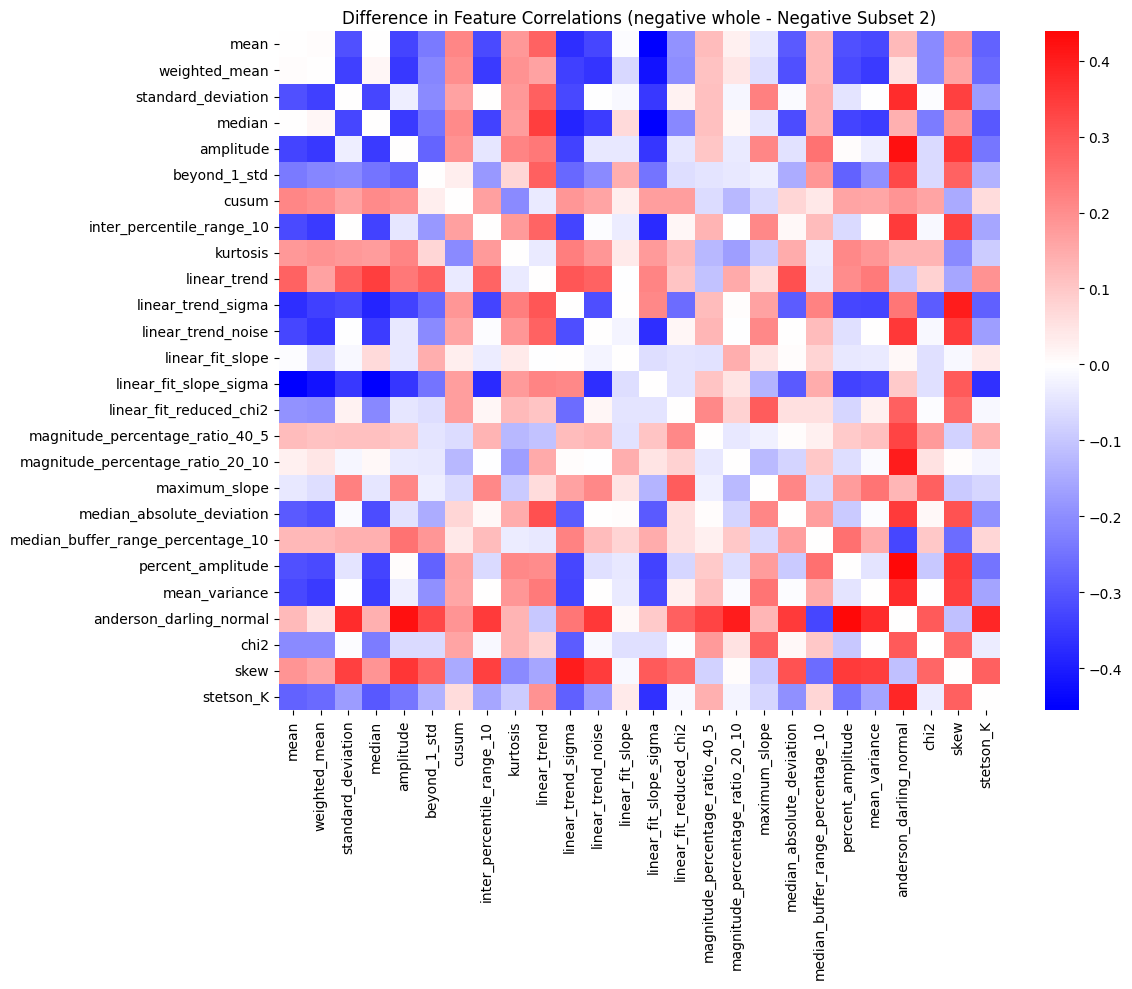

In [79]:
corr_diff = corr_diffs["corr_diff_4"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset 2)")
plt.tight_layout()
plt.show()

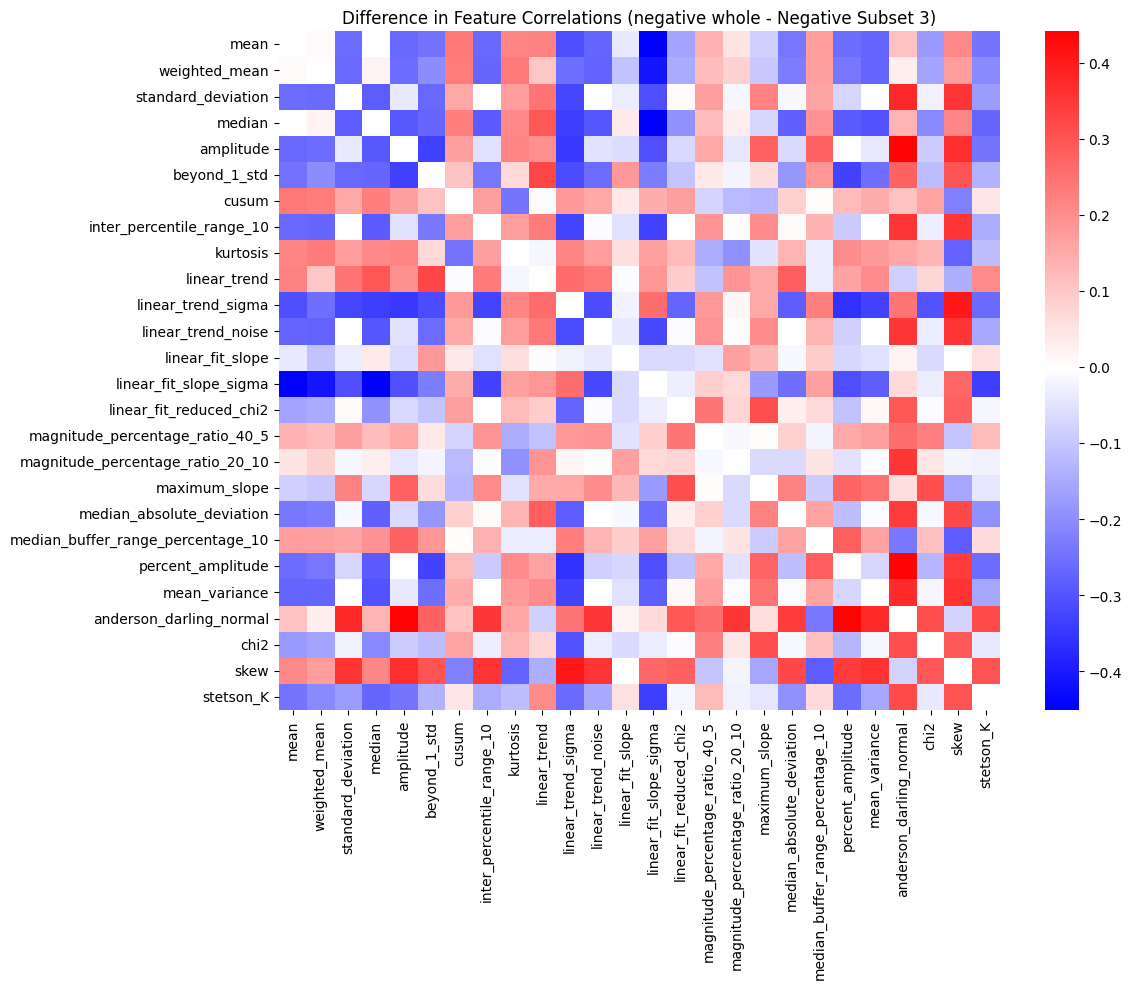

In [80]:
corr_diff = corr_diffs["corr_diff_5"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset 3)")
plt.tight_layout()
plt.show()

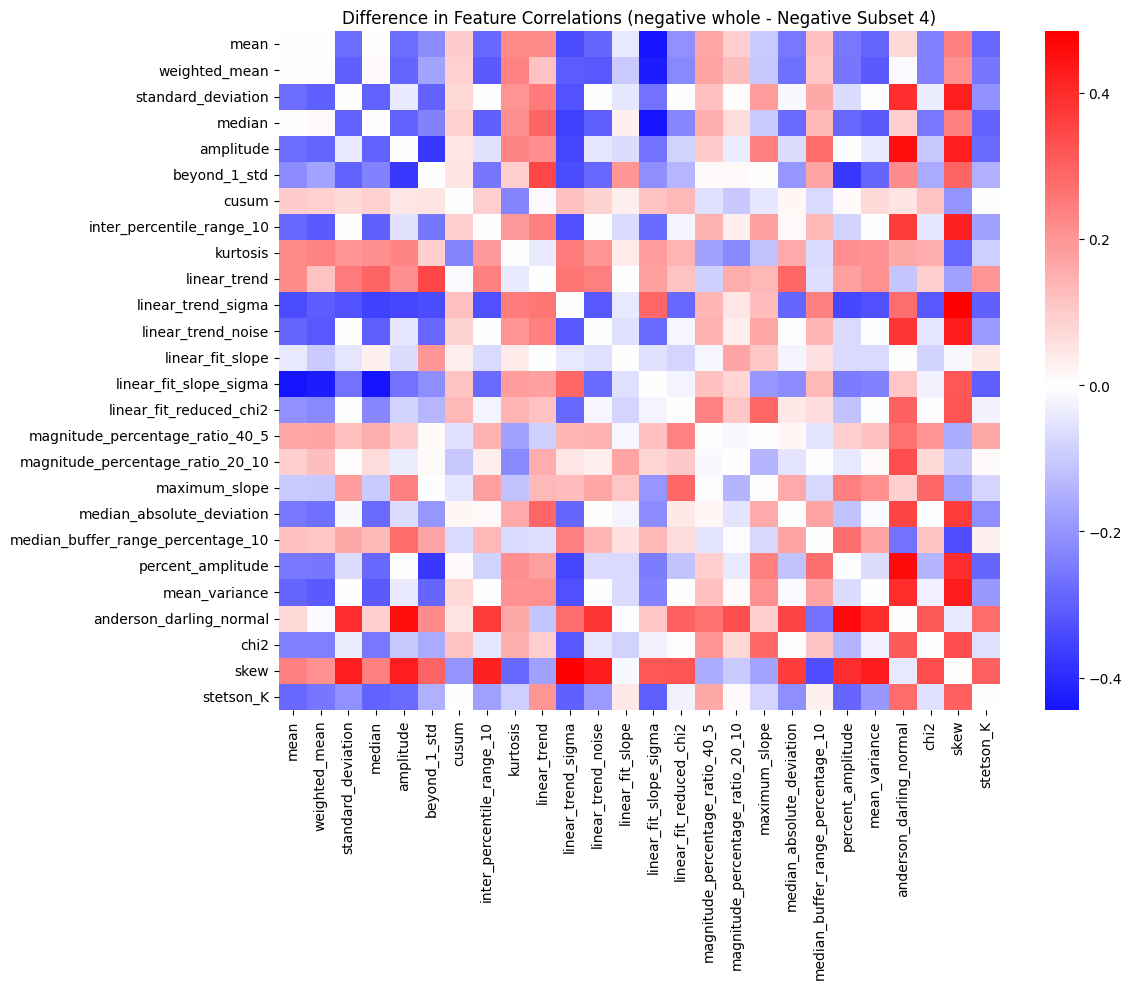

In [81]:
corr_diff = corr_diffs["corr_diff_6"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset 4)")
plt.tight_layout()
plt.show()

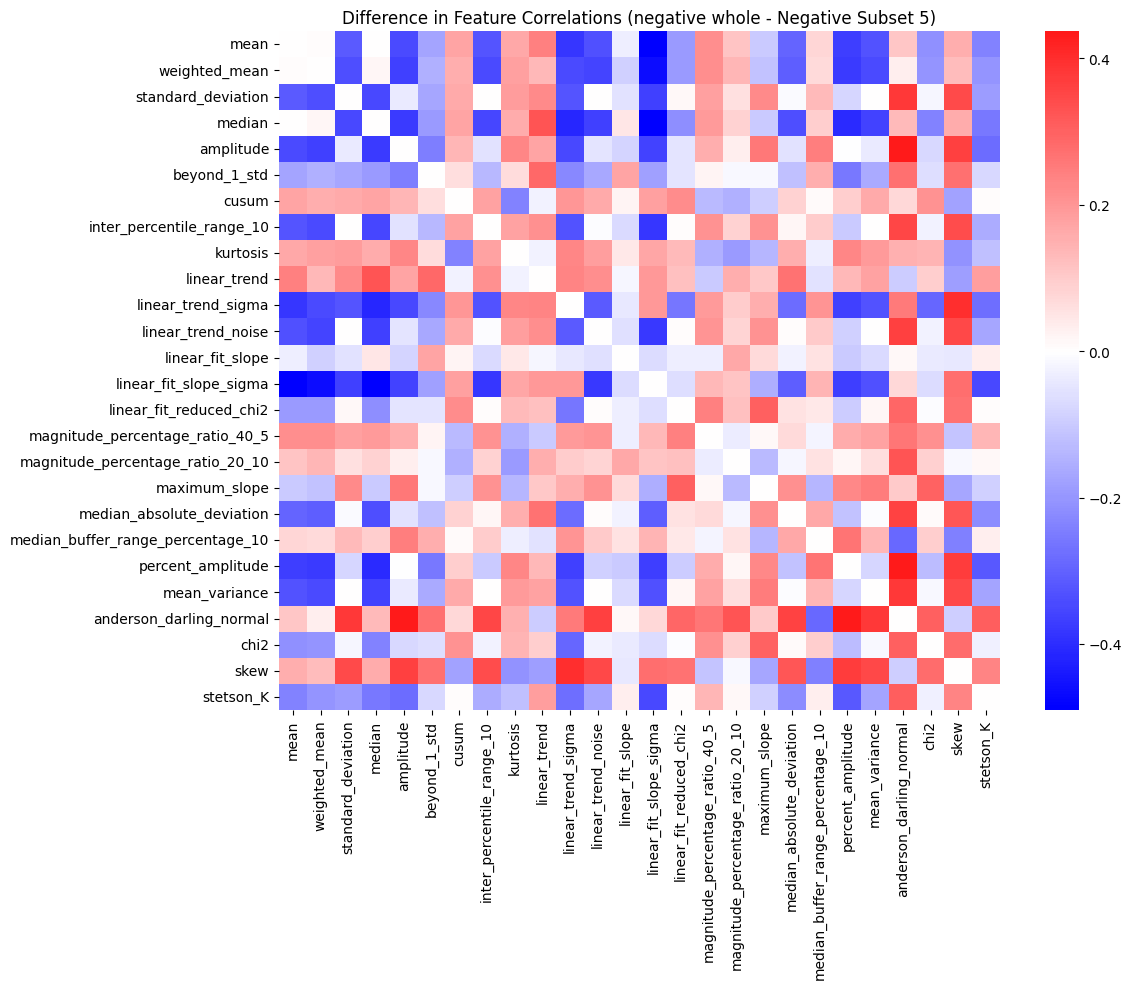

In [83]:
corr_diff = corr_diffs["corr_diff_7"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset 5)")
plt.tight_layout()
plt.show()

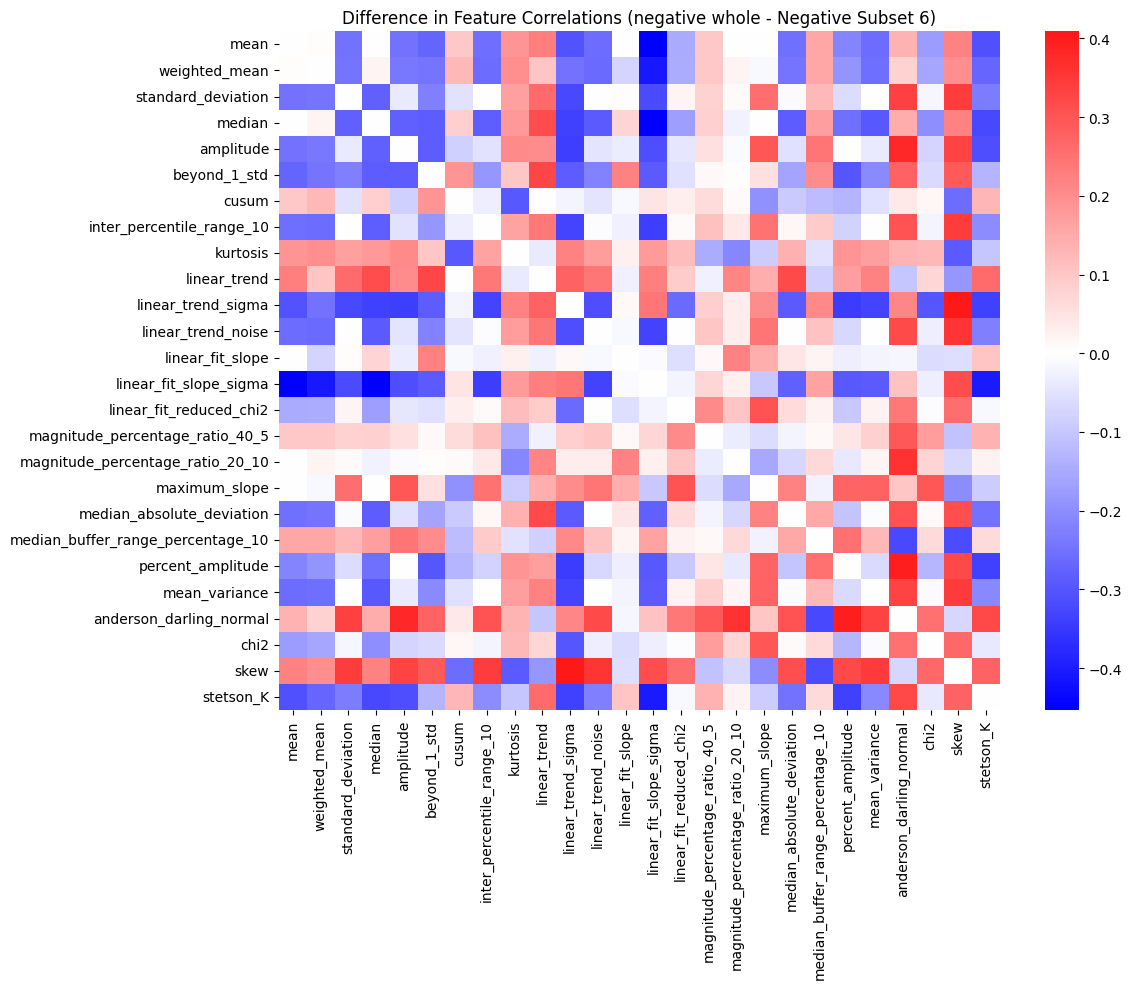

In [84]:
corr_diff = corr_diffs["corr_diff_8"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset 6)")
plt.tight_layout()
plt.show()

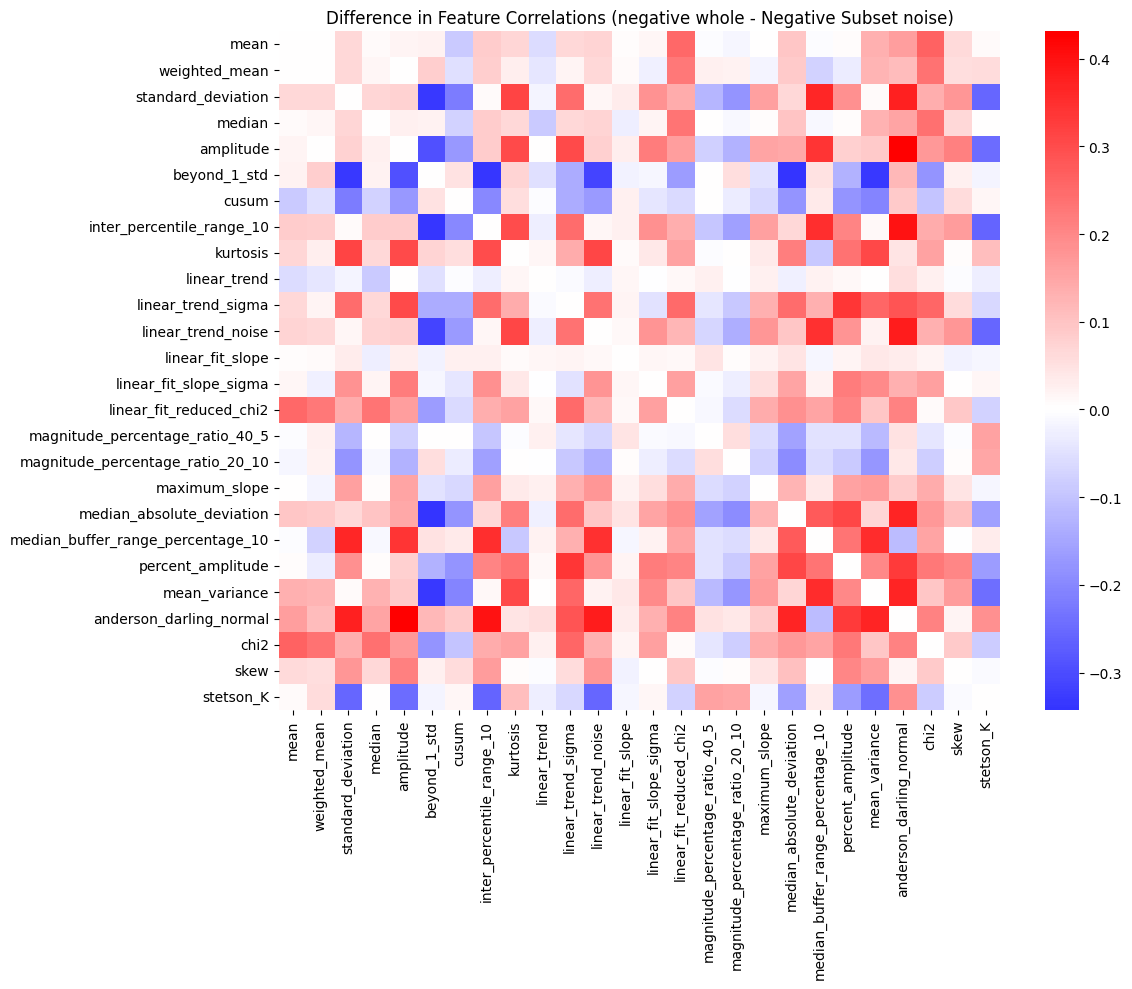

In [85]:
corr_diff = corr_diffs["corr_diff_12"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title("Difference in Feature Correlations (negative whole - Negative Subset noise)")
plt.tight_layout()
plt.show()

In [86]:
import pandas as pd
import numpy as np
import glob

# Find all 12 parquet files
neg_files = sorted(glob.glob("negative_subset_*.parquet"))

In [87]:
# Store sampled dataframes
sampled_list = []

In [90]:
# Sample 10 rows from each subset
for f in neg_files:
    df = pd.read_parquet(f)
# Randomly sample 10 rows (or all if file has <10)
    n = min(10, len(df))
    sampled = df.sample(n, random_state=42)
    sampled_list.append(sampled)
    #print(f"✅ Sampled {n} rows from {f}"

In [91]:
combined_df = pd.concat(sampled_list, ignore_index=True)
# Shuffle the combined data 
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [92]:
# Save to new parquet
combined_df.to_parquet("negative_combined_120.parquet", index=False)


In [93]:
import pandas as pd

# Load your parquet file
df = pd.read_parquet("negative_combined_120.parquet")

# Display first few rows
print(df.head())

         object       mean  weighted_mean  standard_deviation     median  \
0  ZTF18aazmegd  16.951646      16.368075            1.055790  17.298720   
1  ZTF18aayozxu  17.729992      16.571763            1.301323  18.150316   
2  ZTF18aayozjc  19.666773      18.561190            0.944122  20.015309   
3  ZTF18aazmxof  14.114545      14.111335            0.245334  14.071667   
4  ZTF18abebexb  17.978241      17.236498            0.943929  18.140956   

   amplitude  beyond_1_std     cusum  inter_percentile_range_10  kurtosis  \
0   2.498648      0.273326  0.253574                   2.871053 -0.014166   
1   2.163574      0.423522  0.276256                   3.258918 -1.440117   
2   1.975342      0.319867  0.198479                   2.598570 -0.585859   
3   0.707990      0.310011  0.176552                   0.662759  0.683564   
4   2.068290      0.300565  0.252862                   2.816945  0.243427   

   ...  maximum_slope  median_absolute_deviation  \
0  ...     294.399578       

In [94]:
print("\nShape:", df.shape)
print("\nColumns:", df.columns.tolist())


Shape: (120, 28)

Columns: ['object', 'mean', 'weighted_mean', 'standard_deviation', 'median', 'amplitude', 'beyond_1_std', 'cusum', 'inter_percentile_range_10', 'kurtosis', 'linear_trend', 'linear_trend_sigma', 'linear_trend_noise', 'linear_fit_slope', 'linear_fit_slope_sigma', 'linear_fit_reduced_chi2', 'magnitude_percentage_ratio_40_5', 'magnitude_percentage_ratio_20_10', 'maximum_slope', 'median_absolute_deviation', 'median_buffer_range_percentage_10', 'percent_amplitude', 'mean_variance', 'anderson_darling_normal', 'chi2', 'skew', 'stetson_K', 'cluster']


In [95]:
import pandas as pd

# Load your parquet file
df_combined_neg= pd.read_parquet("negative_combined_120.parquet")

features_combined_neg = df_combined_neg.drop(columns=['object_name'], errors='ignore')
features_combined_neg_numeric = features_combined_neg.select_dtypes(include='number')
corr_combined_neg= features_combined_neg_numeric.corr()

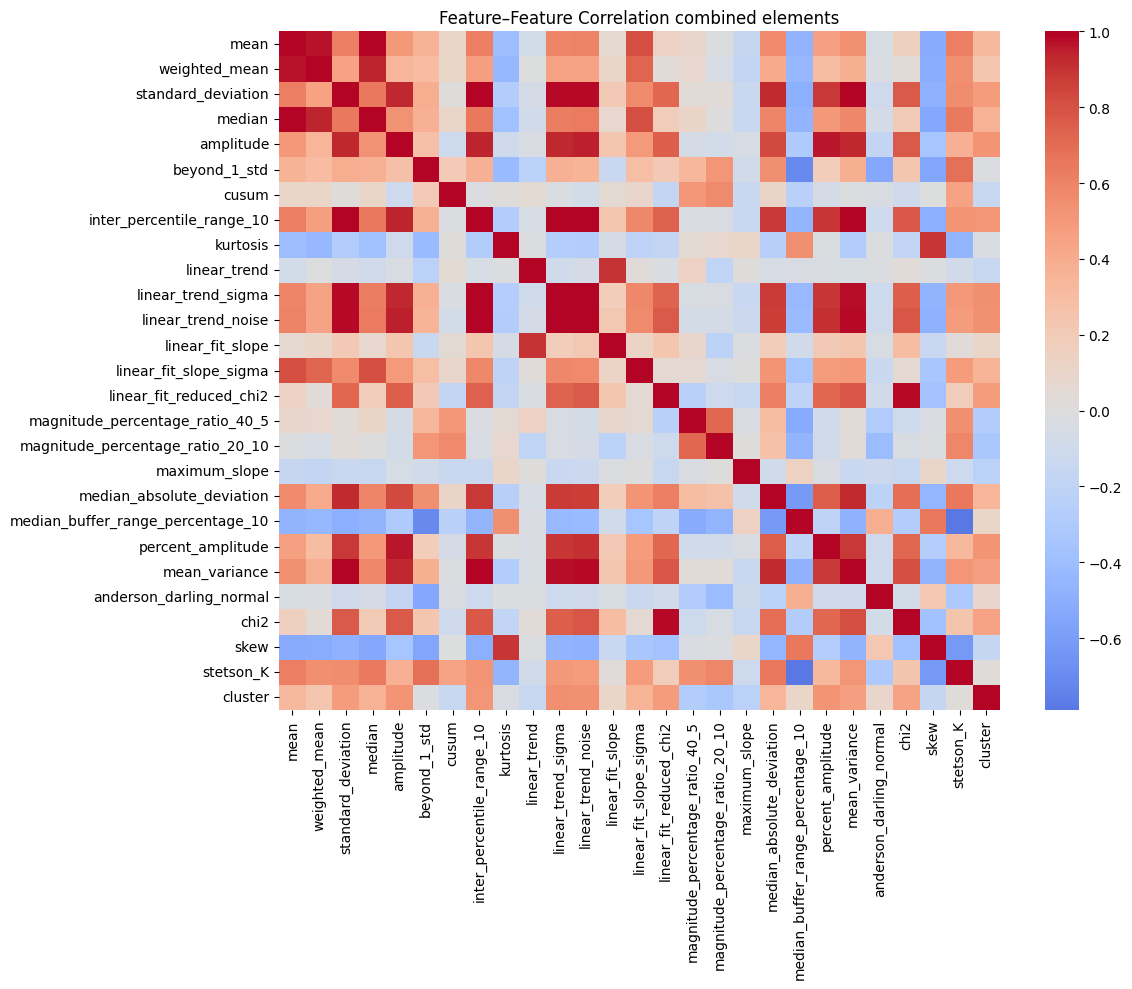

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_combined_neg, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation combined elements')
plt.tight_layout()
plt.show()


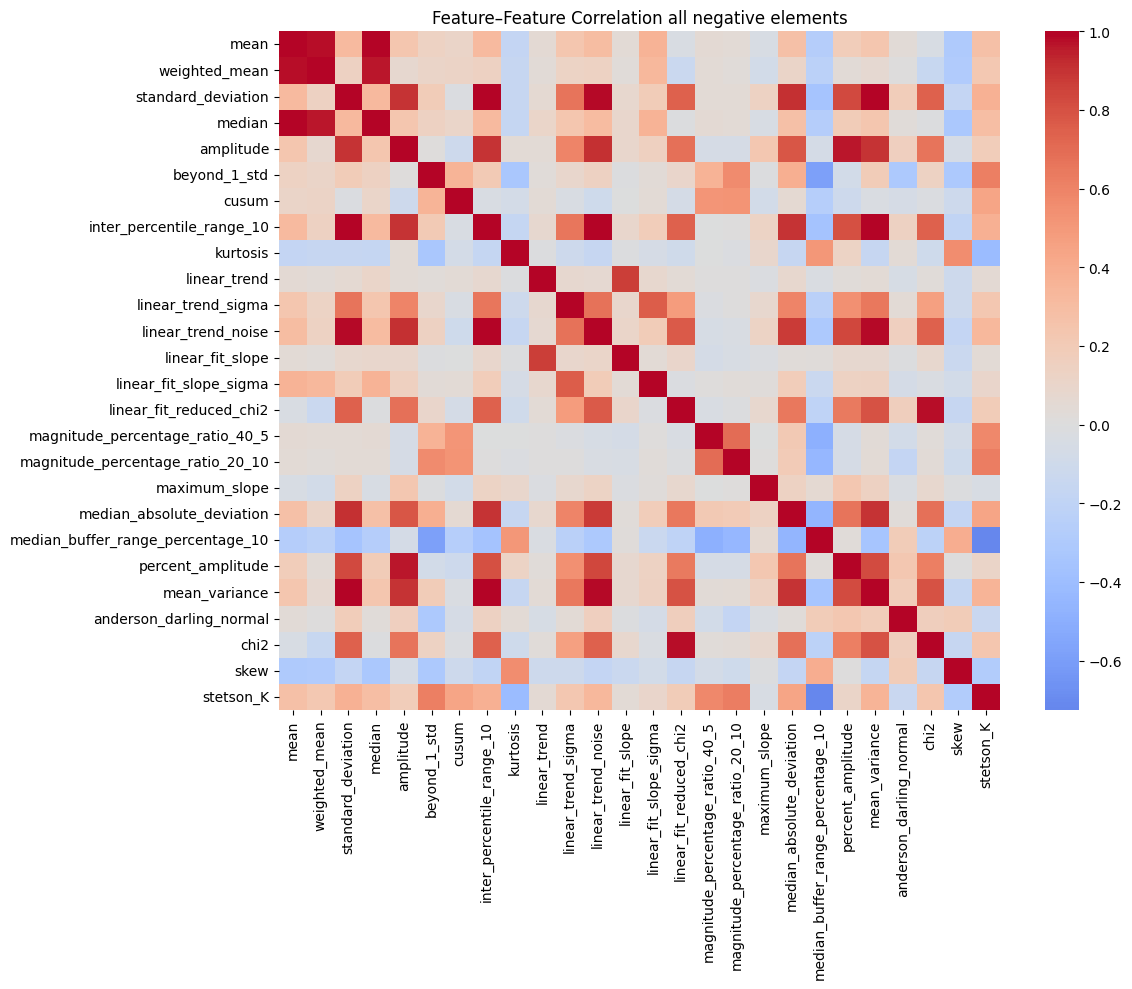

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
df_negative = pd.read_csv("lightcurve_features_26_negative.parquet")  # use read_parquet, not read_csv

# Keep only numeric columns for correlation
corr_negative = df_negative.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_negative, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation all negative elements')
plt.tight_layout()
plt.show()


In [100]:
corr_diff = corr_negative - corr_combined_neg

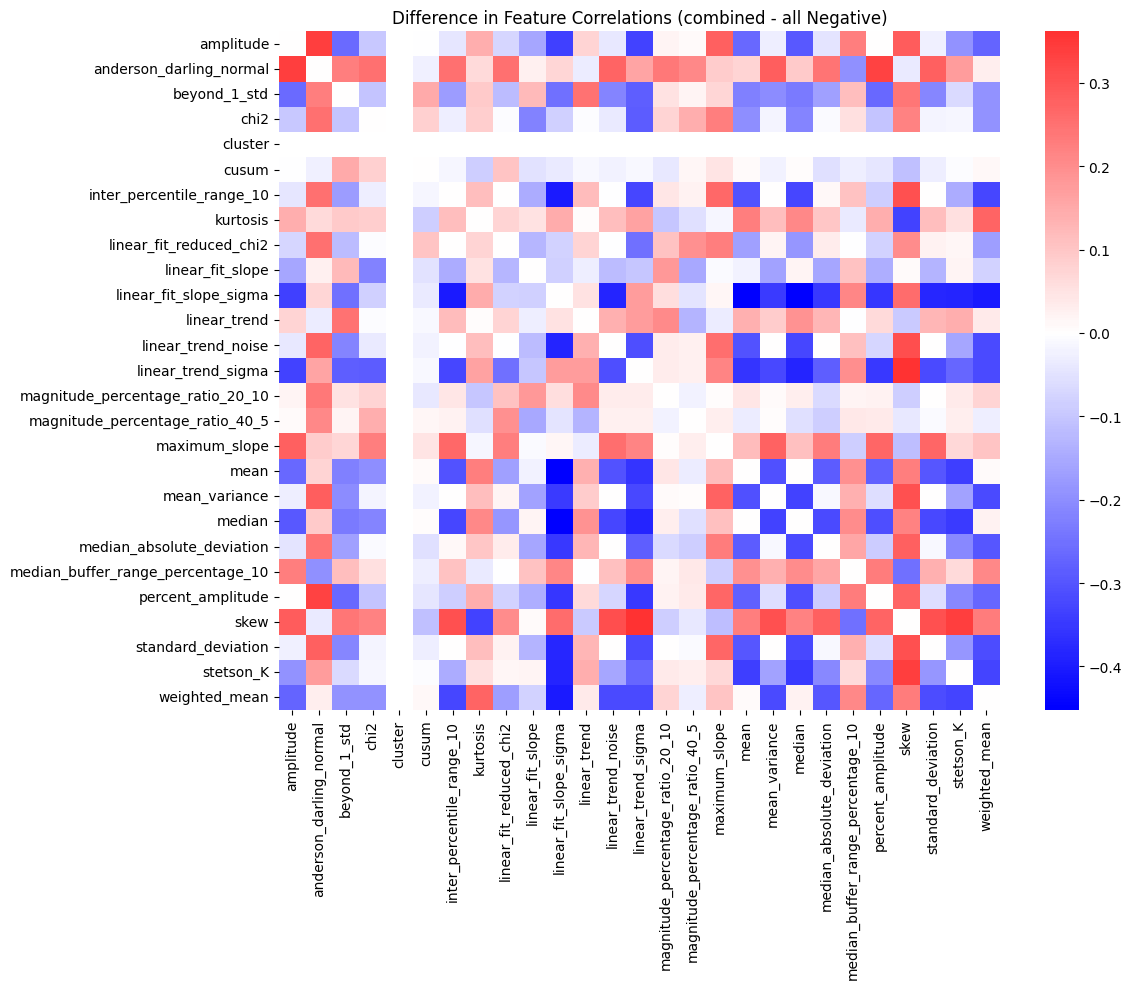

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title('Difference in Feature Correlations (combined - all Negative)')
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
df_subset_10 =pd.read_parquet("negative_combined_120.parquet")
features_subset_10 = df_subset_10 .drop(columns=['object_name','cluster'], errors='ignore')
features_subset_10_numeric = features_subset_10.select_dtypes(include='number')
corr_subset_10 = features_subset_10_numeric.corr()

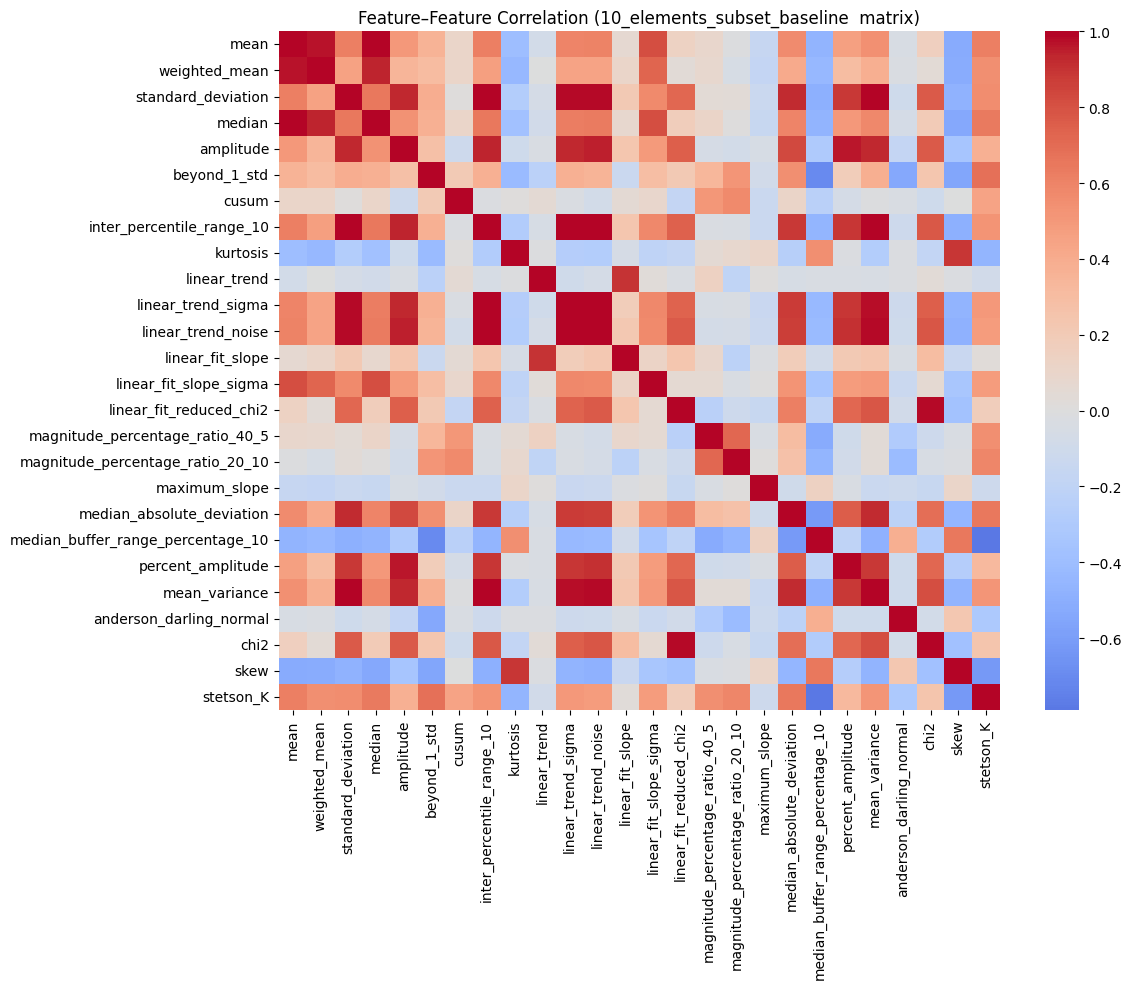

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset_10, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (10_elements_subset_baseline  matrix)')
plt.tight_layout()
plt.show()

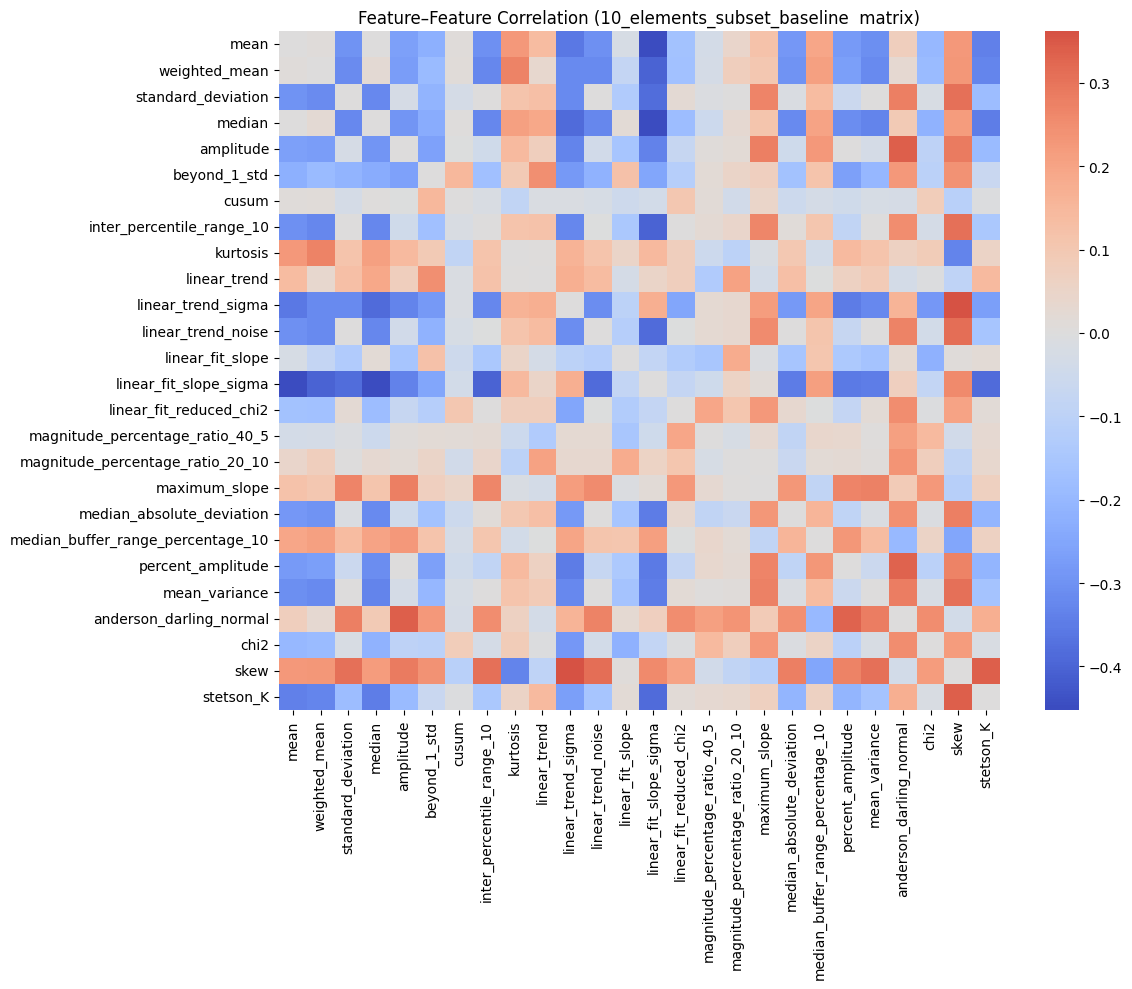

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import glob

# --- Load  negative dataset correctly ---
df_negative = pd.read_csv("lightcurve_features_26_negative.parquet")  # use read_parquet, not read_csv

# Keep only numeric columns for correlation
corr_negative = df_negative.select_dtypes(include=[np.number]).corr()

diff_1=corr_negative-corr_subset_10
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(diff_1, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (10_elements_subset_baseline  matrix)')
plt.tight_layout()
plt.show()

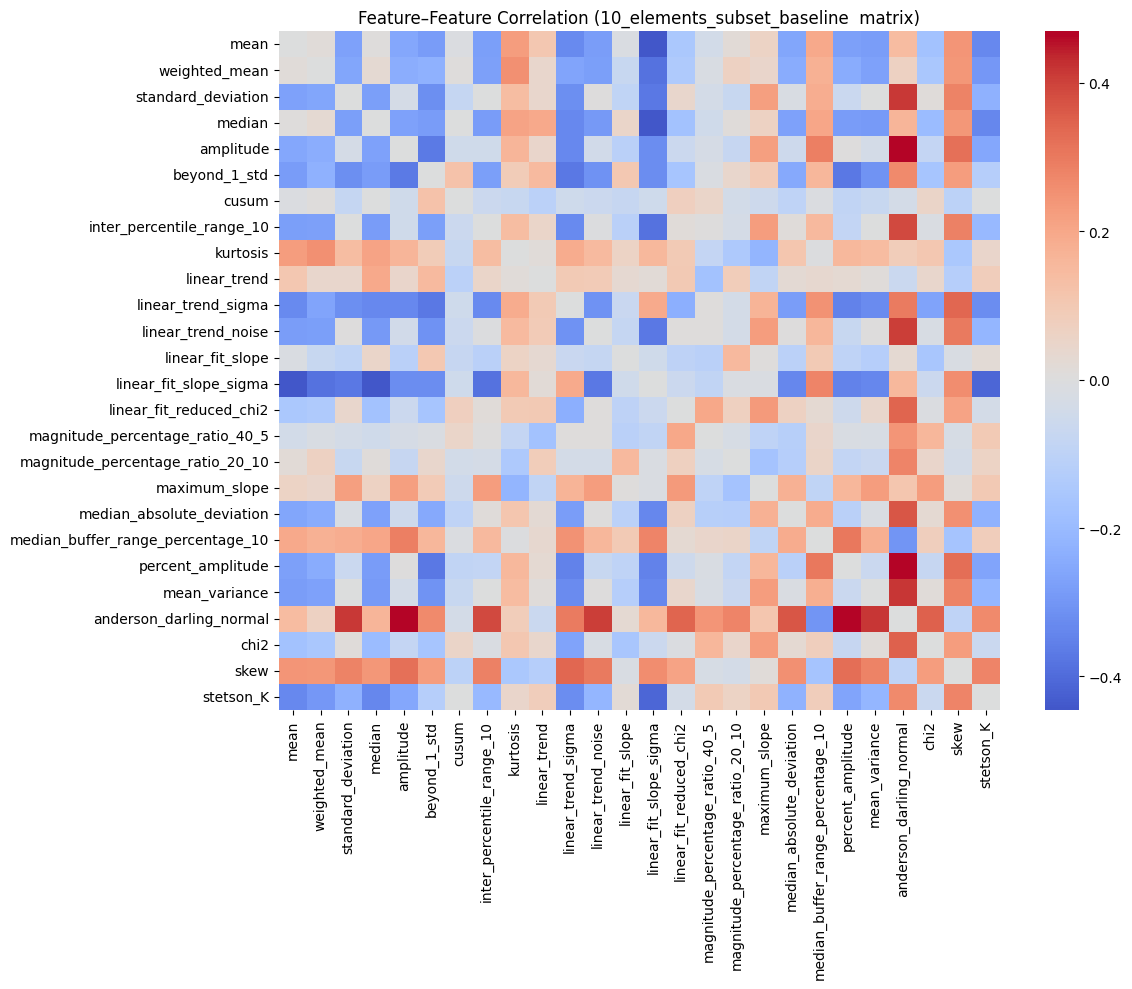

In [12]:
import pandas as pd
df_subset_15 =pd.read_parquet("negative_combined_180.parquet")
features_subset_15 = df_subset_15 .drop(columns=['object_name','cluster'], errors='ignore')
features_subset_15_numeric = features_subset_15.select_dtypes(include='number')
corr_subset_15 = features_subset_15_numeric.corr()
corr_negative = df_negative.select_dtypes(include=[np.number]).corr()

diff_2=corr_negative-corr_subset_15
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(diff_2, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (10_elements_subset_baseline  matrix)')
plt.tight_layout()
plt.show()

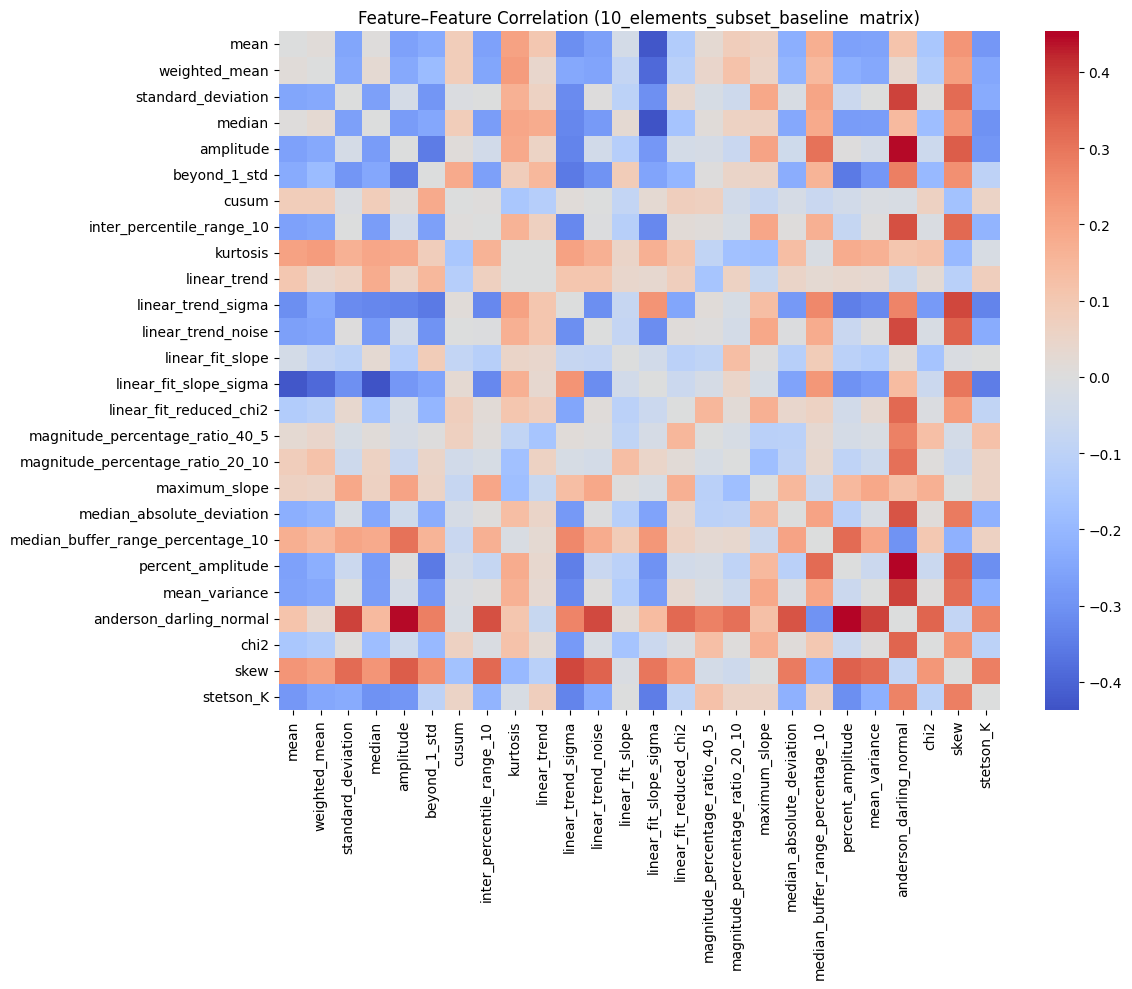

In [13]:
import pandas as pd
df_subset_20=pd.read_parquet("negative_combined_240.parquet")
features_subset_20 = df_subset_20 .drop(columns=['object_name','cluster'], errors='ignore')
features_subset_20_numeric = features_subset_20.select_dtypes(include='number')
corr_subset_20 = features_subset_20_numeric.corr()
corr_negative = df_negative.select_dtypes(include=[np.number]).corr()

diff_3=corr_negative-corr_subset_20
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(diff_3, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (10_elements_subset_baseline  matrix)')
plt.tight_layout()
plt.show()

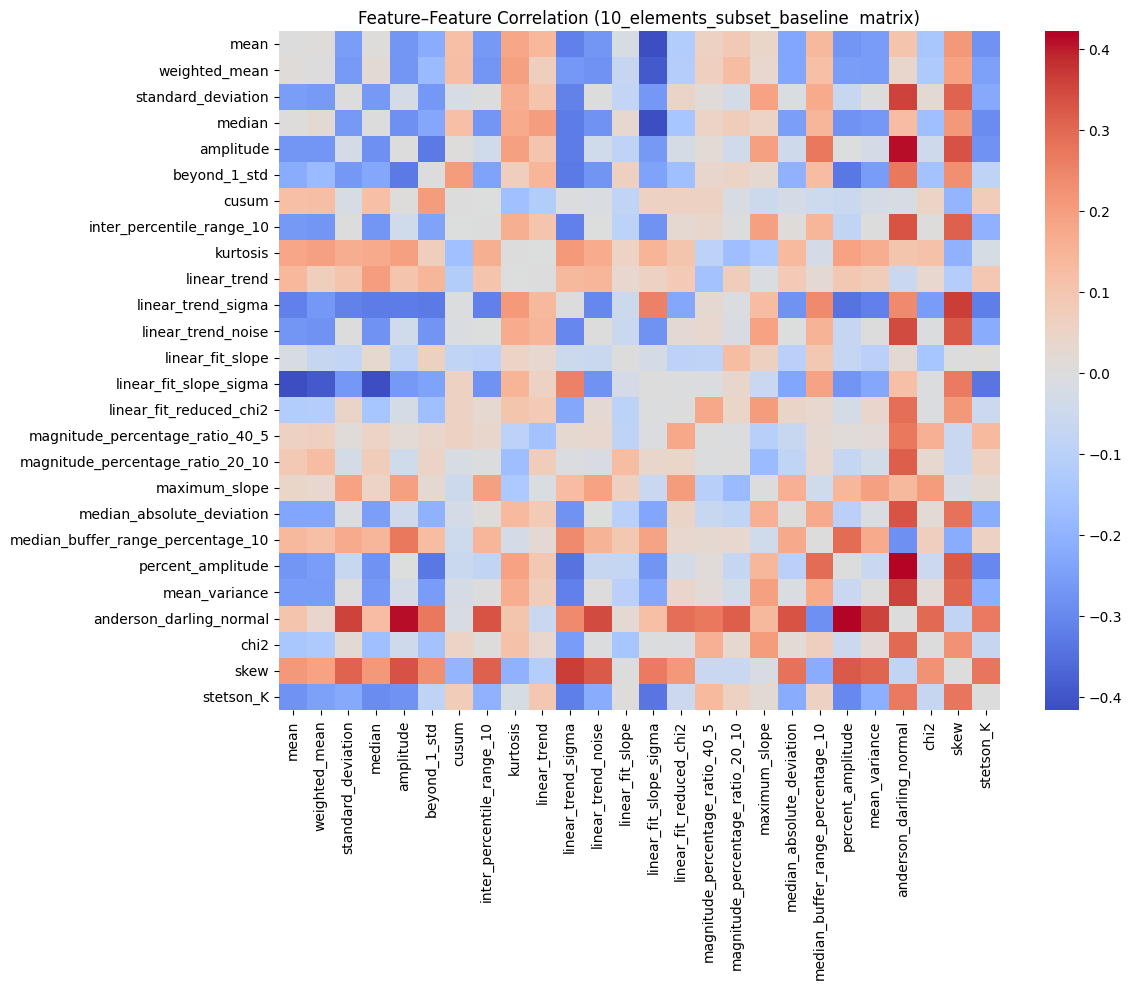

In [14]:
import pandas as pd
df_subset_25=pd.read_parquet("negative_combined_300.parquet")
features_subset_25 = df_subset_25 .drop(columns=['object_name','cluster'], errors='ignore')
features_subset_25_numeric = features_subset_25.select_dtypes(include='number')
corr_subset_25 = features_subset_25_numeric.corr()
corr_negative = df_negative.select_dtypes(include=[np.number]).corr()

diff_4=corr_negative-corr_subset_25
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(diff_4, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (10_elements_subset_baseline  matrix)')
plt.tight_layout()
plt.show()

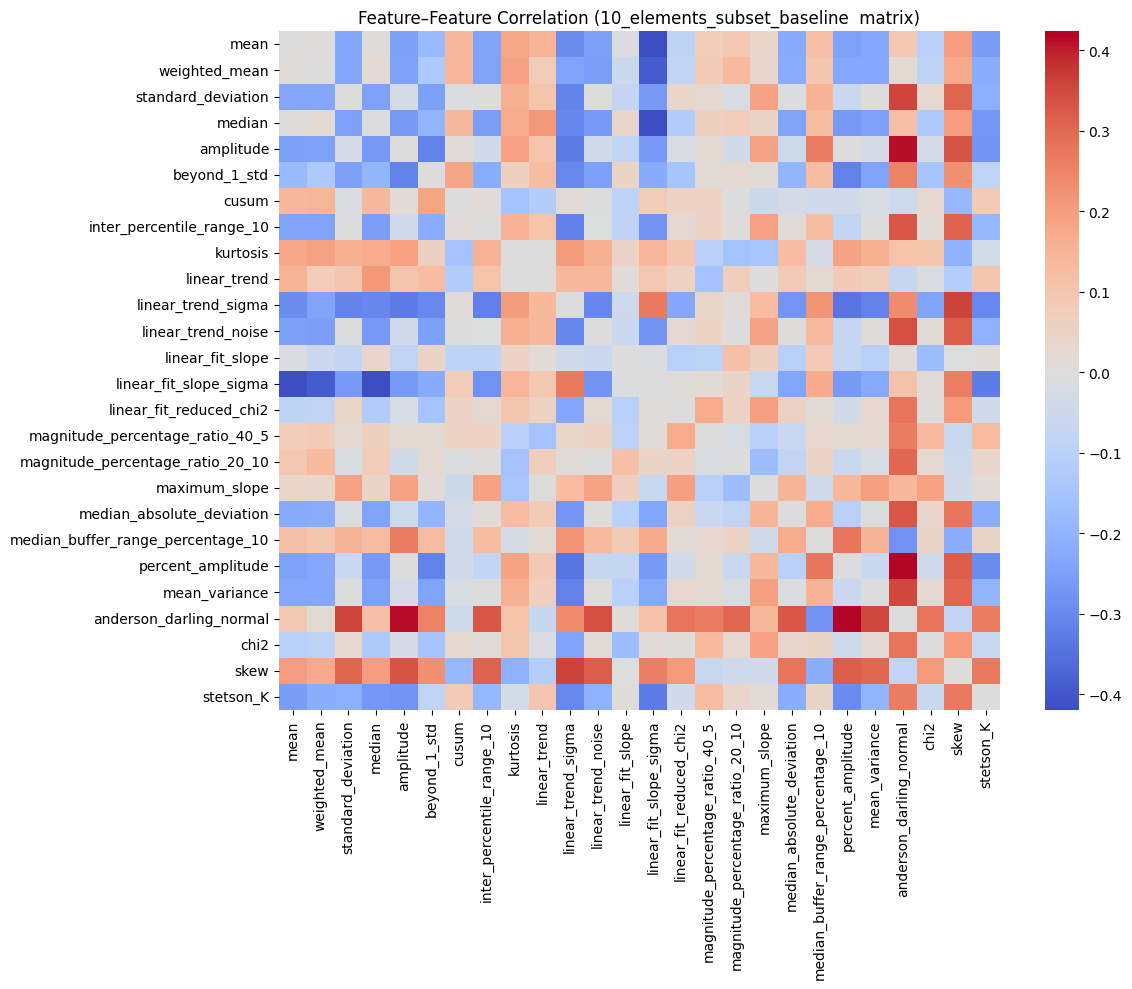

In [15]:
import pandas as pd
df_subset_30=pd.read_parquet("negative_combined_360.parquet")
features_subset_30 = df_subset_30 .drop(columns=['object_name','cluster'], errors='ignore')
features_subset_30_numeric = features_subset_30.select_dtypes(include='number')
corr_subset_30 = features_subset_30_numeric.corr()
corr_negative = df_negative.select_dtypes(include=[np.number]).corr()

diff_5=corr_negative-corr_subset_30
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(diff_5, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (10_elements_subset_baseline  matrix)')
plt.tight_layout()
plt.show()